# Applying supervised learning to predict student dropout

In this project, we will examine student data and use supervised learning techniques to predict whether a student will drop out.

You will work with the data in three distinct stages:

1.  Applicant and course information
2.  Student and engagement data
3.  Academic performance data

These stages reflect real-world data journey and how student information has progressed and become available.

## Business context

The partner organisation specialises in providing educational services and resources to students and professionals across various fields. The company's primary focus is on enhancing learning experiences through a range of services, including online courses, tutoring, and educational consulting. By leveraging cutting-edge technology and a team of experienced educators, the organisation aims to bridge the gap between traditional learning methods and the evolving needs of today's learners.

The organisation serves its university partners by establishing strategic partnerships to enhance the universities’ global reach and diversity. It supports the universities in their efforts to attract international students, thereby enriching the cultural and academic landscape of their campuses. It works closely with university faculty and staff to ensure that the universities are prepared and equipped to welcome and support a growing international student body. Its partnership with universities also offers international students a seamless transition into their chosen academic environment.

The organisation runs several International Study Centres across the UK and Dublin in partnership with universities with the aim of preparing a pipeline of talented international students from diverse backgrounds for degree study. These centres help international students adapt to the academic, cultural, and social aspects of studying abroad. This is achieved by improving conversational and subject-specific language skills and academic readiness before students progress to a full degree programme at university.

Through its comprehensive suite of services, it supports learners and universities at every stage of their educational journey, from high school to postgraduate studies. Its approach is tailored to meet the unique needs of each learner, offering personalised learning paths and flexible scheduling options to accommodate various learning styles and commitments.

The organisation's services are designed to be accessible and affordable, making quality education a reality for many individuals. By focusing on the integration of technology and personalised learning, the company aims to empower learners to achieve their full potential and succeed in their academic and professional pursuits. The organisation is at the forefront of transforming how people learn and grow through its dedication to innovation and excellence.

The partner organisation has provided you with 3 data sets.


## Objective
By the end of this project, you will have developed the skills and knowledge to apply advanced machine learning techniques to create a predictive model for student dropout. This project will involve comprehensive data exploration, preprocessing, and feature engineering to ensure high-quality input for the models. You will employ and compare multiple predictive algorithms, such as XGBoost, and a neural network-based model, to determine the most effective model for predicting student dropout.

By completing this project, you’ll be able to provide evidence that you can:

- develop accurate predictions across diverse organisational scenarios by building and testing advanced ML models
- inform data-driven decision-making with advanced machine learning algorithms and models
- propose and present effective solutions to organisational problems using data preprocessing, model selection, and insightful analysis techniques.


#Install Keras Tuner, XGBoost and Import the necessary libraries

In [19]:
#Install Keras Tuner and XGBoost packages
!pip install keras_tuner
!pip install xgboost --quiet

#import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    accuracy_score, confusion_matrix, precision_score,
    recall_score, roc_auc_score, f1_score
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.7 MB/s eta 0:00:00


#Define functions to be used for all 3 stages

###Functions to Preprocess Data

In [20]:
#Define a function to check unique and missing values
def check_data(df):
    print("Number of unique values in each column:")
    print(df.nunique())
    print("\nNumber of missing values in each column:")
    print(df.isnull().sum())

#Define a function to convert Date of Birth to Age
def preprocess_age(df):
    df['DateofBirth'] = pd.to_datetime(df['DateofBirth'], format='%d/%m/%Y') # Convert the DOB to datetime
    today = pd.Timestamp('now')
    df['Age'] = (today - df['DateofBirth']).dt.days // 365
    df = df.drop(['DateofBirth'], axis=1)
    return df

def encode_data(df):
    # Custom binary encoding for Gender and CompletedCourse
    df['Gender'] = df['Gender'].map({'Male': 0, 'Female': 1})
    df['CompletedCourse'] = df['CompletedCourse'].map({'No': 0, 'Yes': 1})

    # Label Encoding for CourseLevel and BookingType
    label_encoder = LabelEncoder()
    df['CourseLevel'] = label_encoder.fit_transform(df['CourseLevel'])
    df['BookingType'] = label_encoder.fit_transform(df['BookingType'])


    # One-hot encoding for the rest of the categorical columns
    categorical_cols = df.select_dtypes(include='object').columns
    df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    return df

# Define a function to split the data
def split_data(X, y, test_size=0.2, random_state=42):
    """Splits data into training, validation, and test sets."""
    # Split data into training and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Split the train data further into train and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=random_state)

    return X_train, X_val, X_test, y_train, y_val, y_test

# Define a function to standardize features
def standardize_data(X_train, X_val, X_test):

    """Standardizes features using StandardScaler."""
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns = X_val.columns)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler

# Handle imbalance with class weights
def class_weights_for_imbalanced_data(y_train):
    """Computes class weights for imbalanced data."""
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = dict(enumerate(class_weights))
    return class_weights

###Function to build, compile and evaluate the baseline neural network model

In [21]:
#Create a baseline sequential model with 2 input layers having 64 and 32
#neurons, activiation function is relu,
#output layer has 1 neuron and sigmoid activation function
def neural_network_baseline_model(X_train, y_train, X_test, y_test, early_stop, class_weights):
  baseline_model = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
  ])

  #compile the baseline model using Adam optimiser with learning rate 0.001
  baseline_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

  #Train the model set aside 0.2 (20%) of training data
  #for validation during training
  baseline_history = baseline_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    verbose=1,
    callbacks=[early_stop]
  )

  # Evaluate baseline
  y_pred_prob = baseline_model.predict(X_test) #generate probability predictions on test set
  y_pred = (y_pred_prob > 0.5).astype(int) #convert probability into binary class prediction using threshold of 0.5

  acc = accuracy_score(y_test, y_pred)
  prec = precision_score(y_test, y_pred)
  rec = recall_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred_prob)
  f1 = f1_score(y_test, y_pred)
  cm = confusion_matrix(y_test, y_pred)

  return {'accuracy': acc, 'precision': prec, 'recall': rec, 'auc': auc, 'f1_score': f1, 'confusion_matrix': cm, 'baseline_history': baseline_history}

###Functions to create & train Hyperparameter tuned model using Keras

In [22]:
#Creates a Keras Sequential model with tunable hyperparameters
def build_hyperparameter_tuned_model(hp, input_shape):
    model = Sequential()
    #tunable no. of units between 64 and 256 in steps of 64
    model.add(Dense(
        units=hp.Int('units_input', min_value=64, max_value=256, step=64),
        activation=hp.Choice('activation_input', values=['relu', 'tanh']),
        input_dim=input_shape
    ))
    model.add(Dense(
        units=hp.Int('units_hidden', min_value=32, max_value=128, step=32),
        activation=hp.Choice('activation_hidden', values=['relu', 'tanh'])
    ))
    #Dropout layer with tunable rate between 0.1 and 0.5 in step of 0.1
    model.add(Dropout(rate=hp.Float('dropout_rate', 0.1, 0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))

    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))
    else:
        optimizer = RMSprop(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [23]:
def neural_network_hypertuned_model(X_train, y_train, X_test, y_test, early_stop, class_weights):
  #Prepares the hyperparameter tuning process
  tuner = kt.RandomSearch(
      lambda hp: build_hyperparameter_tuned_model(hp, input_shape=X_train.shape[1]),
      objective='val_accuracy', #metric to optimise during search
      max_trials=10,
      executions_per_trial=1, #The number of times to train the model for each hyperparameter combination.
      directory='tuner_results',
      project_name='student_dropout'
  )

  #prints hyperparameter being tuned and their possible values
  tuner.search_space_summary()

  #Hyperparameter tuning process
  tuner.search(
      X_train, y_train,
      validation_split=0.2,
      epochs=20,
      batch_size=32,
      class_weight=class_weights,
      callbacks=[early_stop],
      verbose=1
  )

  #Retrieve the best hyperparameters found
  best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

  #creates the best model using the best hyperparameters
  best_model = tuner.hypermodel.build(best_hyperparameters)

  #trains the best model using training data and stores training history
  history_best = best_model.fit(
      X_train, y_train,
      validation_split=0.1,
      epochs=20,
      batch_size=32,
      class_weight=class_weights,
      callbacks=[early_stop],
      verbose=1
  )

  #generates probability predictions on unseen test set using trained model
  y_pred_prob_best = best_model.predict(X_test)

  #converts probability predictions into binary class predictions using threshold 0.5
  y_pred_best = (y_pred_prob_best > 0.5).astype(int)

  acc = accuracy_score(y_test, y_pred_best)
  prec = precision_score(y_test, y_pred_best)
  rec = recall_score(y_test, y_pred_best)
  auc = roc_auc_score(y_test, y_pred_prob_best)
  f1 = f1_score(y_test, y_pred_best)
  cm = confusion_matrix(y_test, y_pred_best)

  #return best_hyperparameters
  return {'best_hyperparameters': best_hyperparameters, 'best_tuned_model': best_model,
          'accuracy': acc, 'precision': prec, 'recall': rec, 'auc': auc,
          'f1_score': f1, 'confusion_matrix': cm, 'history_best_model': history_best}

###Function to create baseline XGBoost model

In [24]:
def baseline_xgboost_model(X_train, y_train, X_test, y_test, X_val, y_val):
  #Initialise the model
  xgb_model = XGBClassifier(
      objective='binary:logistic',
      eval_metric='logloss',
      use_label_encoder=False,
      random_state=42,
      scale_pos_weight=(len(y_train[y_train == 0]) / len(y_train[y_train == 1]))  # handle imbalance
  )

  #train the model
  xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train),(X_val, y_val)], verbose=False)

  y_pred_xgb = xgb_model.predict(X_test)
  y_pred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

  # Calculate metrics
  acc_xgb = accuracy_score(y_test, y_pred_xgb)
  prec_xgb = precision_score(y_test, y_pred_xgb)
  rec_xgb = recall_score(y_test, y_pred_xgb)
  auc_xgb = roc_auc_score(y_test, y_pred_prob_xgb)
  cm_xgb = confusion_matrix(y_test, y_pred_xgb)
  f1_xgb = f1_score(y_test, y_pred_xgb)

  return  {'accuracy': acc_xgb, 'precision': prec_xgb, 'recall': rec_xgb, 'auc': auc_xgb, 'f1_score': f1_xgb, 'confusion_matrix': cm_xgb, 'xgb_model':xgb_model,}

###Function to create Hyperparameter tuning for XGBoost using GridSearchCV

In [25]:
#Hyperparameter tunig for XGBoost using GridSearchCV
def xgboost_hypertuned_model(X_train, y_train, X_test, y_test):

  #define parameters grid
  param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
  }

  grid_xgb = GridSearchCV(
    estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1
  )

  #Starts search process, will train XGBoost model for every possible combination of hyperparameters
  #xgb_best_parameters = grid_xgb.fit(X_train, y_train)
  grid_xgb.fit(X_train, y_train)

  best_xgb = grid_xgb.best_estimator_
  y_pred_best_xgb = best_xgb.predict(X_test)

  # Calculate metrics
  acc_best_xgb = accuracy_score(y_test, y_pred_best_xgb)
  prec_best_xgb = precision_score(y_test, y_pred_best_xgb)
  rec_best_xgb = recall_score(y_test, y_pred_best_xgb)
  auc_best_xgb = roc_auc_score(y_test, best_xgb.predict_proba(X_test)[:, 1])
  f1_best_xgb = f1_score(y_test, y_pred_best_xgb)
  cm_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)

  return  {'accuracy': acc_best_xgb, 'precision': prec_best_xgb, 'recall': rec_best_xgb,
           'auc': auc_best_xgb, 'f1_score': f1_best_xgb, 'confusion_matrix': cm_best_xgb,
           'best_tuned_xgb':best_xgb,'best_tuned_xgb_parameters': grid_xgb.best_params_}

###Functions for Plots and Loss Curves

In [26]:
def plot_xgboost_feature_importance(best_xgb_model, title="Top 10 Feature Importances"):
  """
  Plots the top 20 feature importances from a trained XGBoost model.

  Args:
    best_xgb_model: The trained XGBoost model object.
    title: The title for the plot.
  """
  xgb.plot_importance(best_xgb_model, max_num_features=10, importance_type='gain', show_values=True)
  plt.title(title)
  plt.xlabel('Importance (Gain)')
  plt.ylabel('Feature')
  plt.tight_layout()
  plt.show()

In [27]:
def plot_model_comparison_results(baseline_results, tuned_results, stage_name):
  """
  Plots a comparison of metrics and confusion matrices for baseline and tuned models.

  Args:
    baseline_results: Dictionary containing results for the baseline model.
    tuned_results: Dictionary containing results for the tuned model.
    stage_name: String indicating the stage (e.g., "Stage 1").
  """
  # Prepare data for plotting all metrics
  metrics = ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1 Score']
  default_scores = [baseline_results['accuracy'], baseline_results['precision'], baseline_results['recall'], baseline_results['auc'], baseline_results['f1_score']]
  tuned_scores = [tuned_results['accuracy'], tuned_results['precision'], tuned_results['recall'], tuned_results['auc'], tuned_results['f1_score']]

  x = np.arange(len(metrics)) # metric labels
  width = 0.35  # width of the bars

  fig, ax = plt.subplots(figsize=(12, 7))
  rects1 = ax.bar(x - width/2, default_scores, width, label=f'Default {stage_name}')
  rects2 = ax.bar(x + width/2, tuned_scores, width, label=f'Tuned {stage_name}')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Score')
  ax.set_title(f'Comparison of Metrics for Default and Tuned Models ({stage_name})')
  ax.set_xticks(x)
  ax.set_xticklabels(metrics)
  ax.legend()

  def autolabel(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      for rect in rects:
          height = rect.get_height()
          ax.annotate(f'{height:.2f}',
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')

  autolabel(rects1)
  autolabel(rects2)

  fig.tight_layout()
  plt.show()

In [28]:
def plot_confusion_metrics_heatmap(baseline_results, tuned_results, stage_name):
  # Plot confusion matrix for Baseline Model
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  sns.heatmap(baseline_results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', cbar=True)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title(f'Confusion Matrix - Baseline Model ({stage_name})')

  # Plot confusion matrix for Tuned Model
  plt.subplot(1, 2, 2)
  sns.heatmap(tuned_results['confusion_matrix'], annot=True, fmt='d', cmap='Reds', cbar=True)
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.title(f'Confusion Matrix - Tuned Model ({stage_name})')

  plt.tight_layout()
  plt.show()

In [29]:
def plot_loss_accuracy_curves(baseline_results, tuned_results, stage_name):
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))

  # Plot Loss Curves on the first subplot
  axes[0].plot(tuned_results['loss'], label='Best Tuned Model Training Loss')
  axes[0].plot(tuned_results['val_loss'], label='Best Tuned Model Validation Loss')
  axes[0].plot(baseline_results['loss'], label='Baseline Model Training Loss')
  axes[0].plot(baseline_results['val_loss'], label='Baseline Model Validation Loss')
  axes[0].set_xlabel('Epochs')
  axes[0].set_ylabel('Loss')
  axes[0].set_title(f'Loss Curves ({stage_name})')

  # Plot Accuracy Curves on the second subplot
  axes[1].plot(tuned_results['accuracy'], label='Best Tuned Model Training Accuracy')
  axes[1].plot(tuned_results['val_accuracy'], label='Best Tuned Model Validation Accuracy')
  axes[1].plot(baseline_results['accuracy'], label='Baseline Model Training Accuracy')
  axes[1].plot(baseline_results['val_accuracy'], label='Baseline Model Validation Accuracy')
  axes[1].set_xlabel('Epochs')
  axes[1].set_ylabel('Accuracy')
  axes[1].set_title(f'Accuracy Curves ({stage_name})')

  # Collect handles and labels from both subplots correctly
  all_handles, all_labels = [], []
  ax_handles, ax_labels = axes[0].get_legend_handles_labels()
  all_handles.extend(ax_handles)
  all_labels.extend(ax_labels)

  # Create a single legend for the entire figure outside the subplots
  fig.legend(all_handles, all_labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=2)
  plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for the legend
  plt.show()

In [30]:
def create_comparison_table(baseline_results, tuned_results):
  """
  Creates a comparison table (DataFrame) for baseline and tuned model results.

  Args:
    baseline_results: Dictionary containing results for the baseline model.
    tuned_results: Dictionary containing results for the tuned model.

  Returns:
    A pandas DataFrame comparing the metrics of the baseline and tuned models.
  """
  comparison_data = {
      'Metric': ['Accuracy', 'Precision', 'Recall', 'AUC', 'F1 Score'],
      'Baseline Model': [
          round(baseline_results['accuracy'], 2),
          round(baseline_results['precision'], 2),
          round(baseline_results['recall'], 2),
          round(baseline_results['auc'], 2),
          round(baseline_results['f1_score'], 2)
      ],
      'Tuned Model': [
          round(tuned_results['accuracy'], 2),
          round(tuned_results['precision'], 2),
          round(tuned_results['recall'], 2),
          round(tuned_results['auc'], 2),
          round(tuned_results['f1_score'], 2)
      ]
  }

  comparison_df = pd.DataFrame(comparison_data)
  return comparison_df

#Stage 1 - EDA, NN and XGBoost

##Pre-processing or EDA for Stage 1 data

**Stage 1: Pre-processing instructions**
- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with > 50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.

In [39]:
# File URL

file_url = "https://drive.google.com/uc?id=1pA8DDYmQuaLyxADCOZe1QaSQwF16q1J6"

In [40]:
# Start coding from here with Stage 1 dataset
import pandas as pd

main_data_stage1 = pd.read_csv(file_url)
main_data_stage1.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen


In [41]:
# Check unique and missing values for Stage 1 dataset
check_data(main_data_stage1)

Number of unique values in each column:
CentreName                  19
LearnerCode              24877
BookingType                  2
LeadSource                   7
DiscountType                11
DateofBirth               4705
Gender                       2
Nationality                151
HomeState                 2448
HomeCity                  5881
CourseLevel                  4
CourseName                 172
IsFirstIntake                2
CompletedCourse              2
ProgressionDegree         2616
ProgressionUniversity       40
dtype: int64

Number of missing values in each column:
CentreName                   0
LearnerCode                  0
BookingType                  0
LeadSource                   0
DiscountType             17464
DateofBirth                  0
Gender                       0
Nationality                  0
HomeState                16134
HomeCity                  3448
CourseLevel                  0
CourseName                   0
IsFirstIntake                0
Comple

In [42]:
# Convert Date of Birth to Age column for Stage 1 dataset
main_data_stage1 = preprocess_age(main_data_stage1)
main_data_stage1.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity,Age
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen,27
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen,27
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen,25
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen,26
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen,29


In [43]:
#Remove columns not useful (LearnerCode), having high cardinality and having > 50% missing values
main_data_stage1 = main_data_stage1.drop(['LearnerCode', 'HomeState', 'HomeCity','DiscountType','ProgressionDegree'], axis=1)
main_data_stage1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CentreName             25059 non-null  object
 1   BookingType            25059 non-null  object
 2   LeadSource             25059 non-null  object
 3   Gender                 25059 non-null  object
 4   Nationality            25059 non-null  object
 5   CourseLevel            25059 non-null  object
 6   CourseName             25059 non-null  object
 7   IsFirstIntake          25059 non-null  bool  
 8   CompletedCourse        25059 non-null  object
 9   ProgressionUniversity  25059 non-null  object
 10  Age                    25059 non-null  int64 
dtypes: bool(1), int64(1), object(9)
memory usage: 1.9+ MB


In [44]:
check_data(main_data_stage1)

Number of unique values in each column:
CentreName                19
BookingType                2
LeadSource                 7
Gender                     2
Nationality              151
CourseLevel                4
CourseName               172
IsFirstIntake              2
CompletedCourse            2
ProgressionUniversity     40
Age                       38
dtype: int64

Number of missing values in each column:
CentreName               0
BookingType              0
LeadSource               0
Gender                   0
Nationality              0
CourseLevel              0
CourseName               0
IsFirstIntake            0
CompletedCourse          0
ProgressionUniversity    0
Age                      0
dtype: int64


In [45]:
# Perform encoding for Stage 1 dataset
main_data_stage1 = encode_data(main_data_stage1)
main_data_stage1.head()

,BookingType,Gender,CourseLevel,IsFirstIntake,CompletedCourse,Age,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,CentreName_ISC_Durham,CentreName_ISC_Holland,...,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex,ProgressionUniversity_VU Amsterdam
0,0,0,3,True,1,27,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,0,0,0,False,1,27,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
2,0,0,2,False,1,25,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
3,0,0,2,True,1,26,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
4,0,0,3,True,1,29,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False


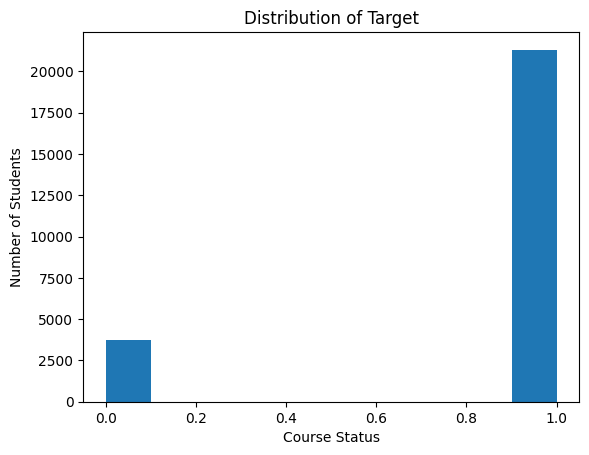

In [46]:
#Set CompletedCourse_Yes as target variable and check histogram for target variable to see if data is imbalanced
target = main_data_stage1['CompletedCourse'].astype(int)
target.hist(grid=False)
plt.title('Distribution of Target')
plt.xlabel('Course Status')
plt.ylabel('Number of Students')
plt.show()

X = main_data_stage1.drop(['CompletedCourse'], axis=1)
y = main_data_stage1['CompletedCourse']

**The findings from Pre-Processing the data:**
- Columns having **high cardinality (> 200 unique values)**: LearnerCode, HomeState, HomeCity, ProgressionDegree have been removed
- Columns having **>50% data missing**: DiscountType, HomeState, HomeCity, ProgressionDegree have been removed
- For **Gender** custom binary encoding is used, Male: 0 and Female: 1
- Since **CourseLevel** and **BookingType** had 4 and 2 unique values respectively, label encoding is executed. This would just reduce the complexity for the model training.
- For rest all categorical columns one-hot encoding is executed,
- **390** columns have been generated after encoding. This dataset with 390 columns will be used for model tuning.
- Looking at the histogram for **CompletedCourse** target variable it shows that the data is **imbalanced** - which means more students have completed the course than students who haven't completed. This will be taken into consideration while creating and tuning the model

##Neural Network - Baseline & Hyperparameter Tuning for Stage 1

### Fetch the results for baseline NN model for stage 1 data

In [49]:
# Split data for Stage 1 dataset
X_train_1, X_val_1, X_test_1, y_train_1, y_val_1, y_test_1 = split_data(X, target)

# Standardise the features with the StandardScaler.
X_train_1, X_val_1, X_test_1, scaler = standardize_data(X_train_1, X_val_1, X_test_1)

#Early stopping callback that is monitoring validation loss,
#the model stops training if validation loss doesn't improve for
#certain number of epochs (patience=3)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True)

class_weights_1 = class_weights_for_imbalanced_data(y_train_1)

# Fetch the Neural Network Baseline model results
baseline_results_stage1 = neural_network_baseline_model(X_train_1, y_train_1, X_test_1, y_test_1, early_stop, class_weights_1)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


452/452 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7689 - loss: 0.5389 - val_accuracy: 0.8163 - val_loss: 0.4882
Epoch 2/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8500 - loss: 0.4069 - val_accuracy: 0.8382 - val_loss: 0.4442
Epoch 3/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8491 - loss: 0.3845 - val_accuracy: 0.8254 - val_loss: 0.4729
Epoch 4/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8591 - loss: 0.3719 - val_accuracy: 0.8160 - val_loss: 0.4901
Epoch 5/20
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8657 - loss: 0.3562 - val_accuracy: 0.8304 - val_loss: 0.4589
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


###Execute the hyperparameter tuning process using stage 1 data

In [50]:
best_tuned_model_stage1 = neural_network_hypertuned_model(X_train_1, y_train_1, X_test_1, y_test_1, early_stop, class_weights_1)

Reloading Tuner from tuner_results/student_dropout/tuner0.json
Search space summary
Default search space size: 7
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
activation_input (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
activation_hidden (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


508/508 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7837 - loss: 0.6173 - val_accuracy: 0.8476 - val_loss: 0.5202
Epoch 2/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8320 - loss: 0.4876 - val_accuracy: 0.8681 - val_loss: 0.3880
Epoch 3/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8343 - loss: 0.4818 - val_accuracy: 0.8770 - val_loss: 0.2971
Epoch 4/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8330 - loss: 0.4933 - val_accuracy: 0.8814 - val_loss: 0.3063
Epoch 5/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8310 - loss: 0.4991 - val_accuracy: 0.8798 - val_loss: 0.3272
Epoch 6/20
508/508 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8142 - loss: 0.5217 - val_accuracy: 0.8576 - val_loss: 0.5963
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


##Compare the results & plots for Neural Network Baseline and Tuned Model (Stage 1)

In [51]:
#prints the hyperparameters for best tuned model
print("\n🔹 Hyperparameters for Best Tuned NN Model (Stage 1)")
for param, value in best_tuned_model_stage1['best_hyperparameters'].values.items():
  print(param, ":", value)


🔹 Hyperparameters for Best Tuned NN Model (Stage 1)
units_input : 192
activation_input : relu
units_hidden : 128
activation_hidden : tanh
dropout_rate : 0.2
optimizer : rmsprop
learning_rate : 0.01


In [52]:
comparison_df_stage1_nn = create_comparison_table(baseline_results_stage1, best_tuned_model_stage1)
print("\nComparison of Baseline and Tuned Neural Network Models (Stage 1)")
display(comparison_df_stage1_nn)


Comparison of Baseline and Tuned Neural Network Models (Stage 1)


,Metric,Baseline Model,Tuned Model
0,Accuracy,0.85,0.88
1,Precision,0.95,0.93
2,Recall,0.86,0.93
3,AUC,0.86,0.85
4,F1 Score,0.91,0.93


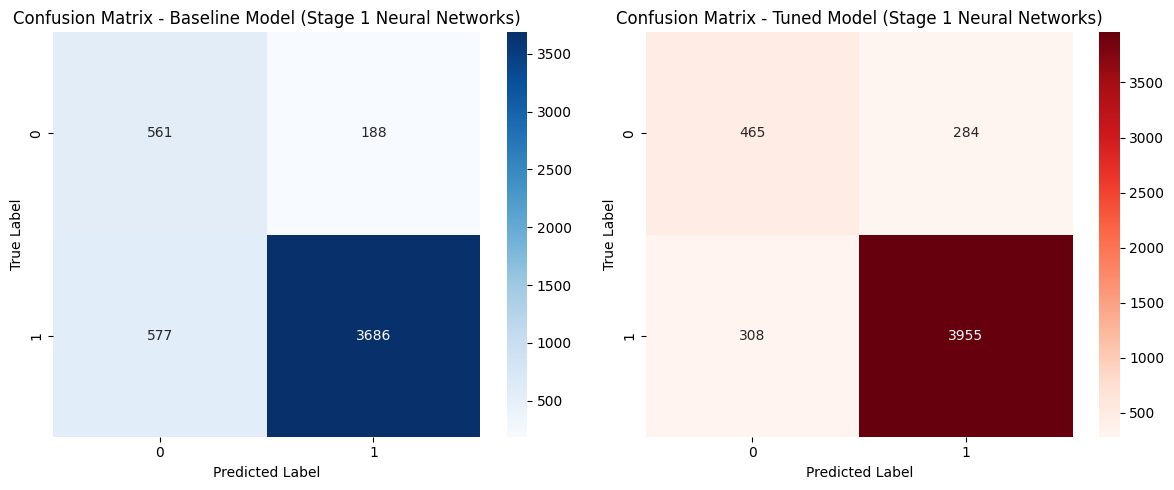

In [53]:
#Plot Heatmap for Confusion Matrix
plot_confusion_metrics_heatmap(baseline_results_stage1, best_tuned_model_stage1, "Stage 1 Neural Networks")

**Baseline Model (Stage 1)**
* True Negatives (TN): 557 → Correctly identified class 0
* False Positives (FP): 192 → Incorrectly predicted 1 for true class 0
* False Negatives (FN): 535 → Incorrectly predicted 0 for true class 1
* True Positives (TP): 3728 → Correctly identified class 1

**Tuned Model (Stage 1)**
* True Negatives (TN): 484 → Slightly fewer than baseline
* False Positives (FP): 265 → Slightly more than baseline
* False Negatives (FN): 337 → **Improved**: fewer missed positives
* True Positives (TP): 3926 → **Improved**: more correctly detected positives

Tuned model correctly identifies more true positives and reduces false negatives compared to the baseline, showing improved sensitivity at the small cost of slightly more false positives


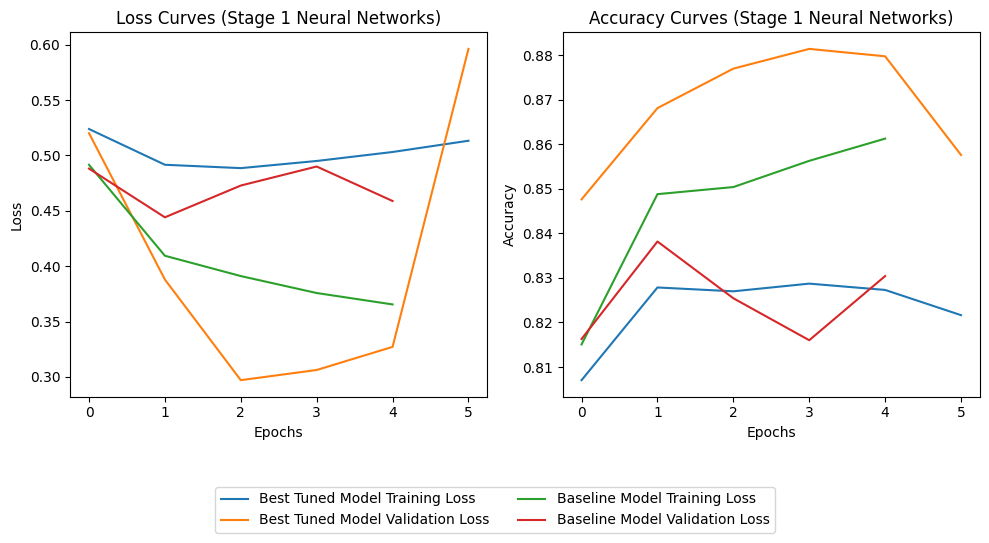

In [54]:
#Plot loss & accuracy curves for Neural Network Baseline and Tuned Model
plot_loss_accuracy_curves(baseline_results_stage1['baseline_history'].history, best_tuned_model_stage1['history_best_model'].history, "Stage 1 Neural Networks")

**Explanation on Comparison:**


*   **Confusion Matrix:**
    * The **confusion matrix** of both baseline and tuned model shows **strong performance on the positive class**.
    * The tuned model **improves Recall** by reducing false negatives (628 → 554) and increasing true positives (3635 → 3709).
    
*   **Loss Curves**
    * Training Loss for both the models decreases smoothly and steadily suggesting **both models are learning**.
    * **Baseline model**: Validation loss slightly increases after early epochs, signs of **mild overfitting**
    * **Tuned model**: Validation loss decreases and stays close to training loss, **better generalizatio**n.
    * Tuning helped reduce overfitting
    * Model trained more efficiently and converged to a lower, more stable loss.

*   **Accuracy Curves**
    * Training Accuracy increases nicely for both the models.
    * **Baseline model**: Validation accuracy plateaus early and stays lower, signs of **underperformance and overfitting**.
    * **Tuned model**: Curves stay close to each other, suggesting good **generalization**. Validation accuracy consistently outperforms baseline.
    * Tuned model learns faster, generalizes better and maintains high validation accuracy with minimal overfitting. This aligns with confusion matrix results.




##Implement XGBoost and Hyperparameter Tuning for Stage 1

### Fetch results for baseline XGBoost model

In [55]:
baseline_xgb_model_stage1 = baseline_xgboost_model(X_train_1, y_train_1, X_test_1, y_test_1, X_val_1, y_val_1)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:58:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


###Fetch results for XGBoost tuned model and Print best hyperparameters

In [56]:
#Print Best parameters that resulted in highest avg score for roc_auc
best_tuned_xgb_stage1 = xgboost_hypertuned_model(X_train_1, y_train_1, X_test_1, y_test_1)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:58:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:59:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:59:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:59:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [21:59:03] WARNING: /w

In [57]:
#Print Best Parameters for XGBoost Tuned Model
print("🔹 Best Parameters for XGBoost Tuned Model:", best_tuned_xgb_stage1['best_tuned_xgb_parameters'])

🔹 Best Parameters for XGBoost Tuned Model: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100}


##Compare results & plots for XGBoost Baseline and Tuned Model (Stage 1)

/tmp/ipython-input-1758773094.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


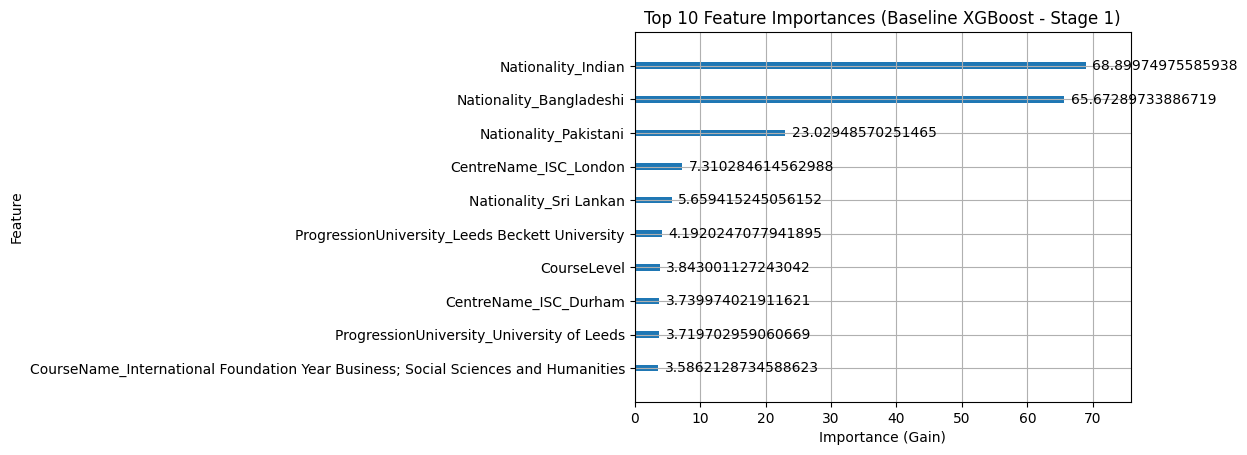

/tmp/ipython-input-1758773094.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


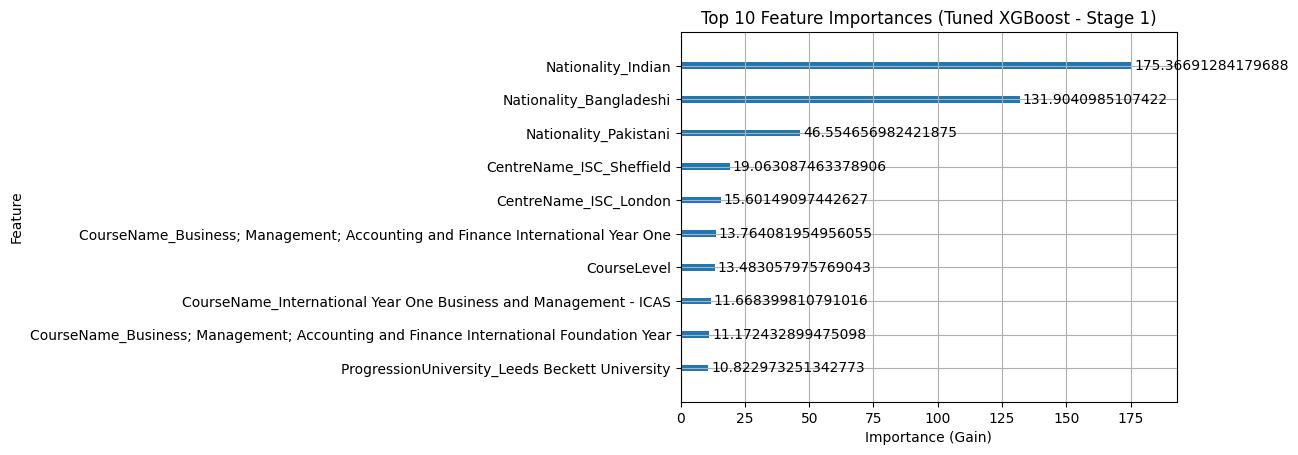

In [58]:
#Plot the feature importance with Stage 1 tuned XGBoost model
plot_xgboost_feature_importance(baseline_xgb_model_stage1['xgb_model'], title='Top 10 Feature Importances (Baseline XGBoost - Stage 1)')
plot_xgboost_feature_importance(best_tuned_xgb_stage1['best_tuned_xgb'], title='Top 10 Feature Importances (Tuned XGBoost - Stage 1)')

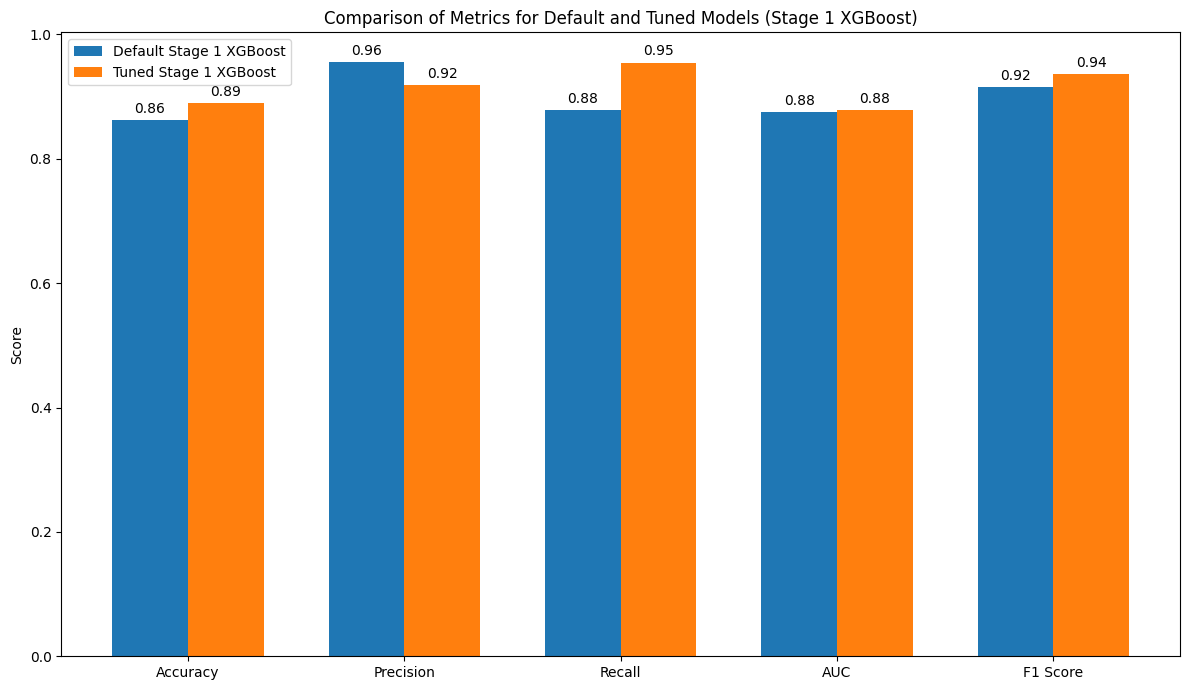

In [59]:
#Plot comparison metrics for Default & Tuned Model (XGBoost) and Heatmap for Confusion Matrix
plot_model_comparison_results(baseline_xgb_model_stage1, best_tuned_xgb_stage1, "Stage 1 XGBoost")

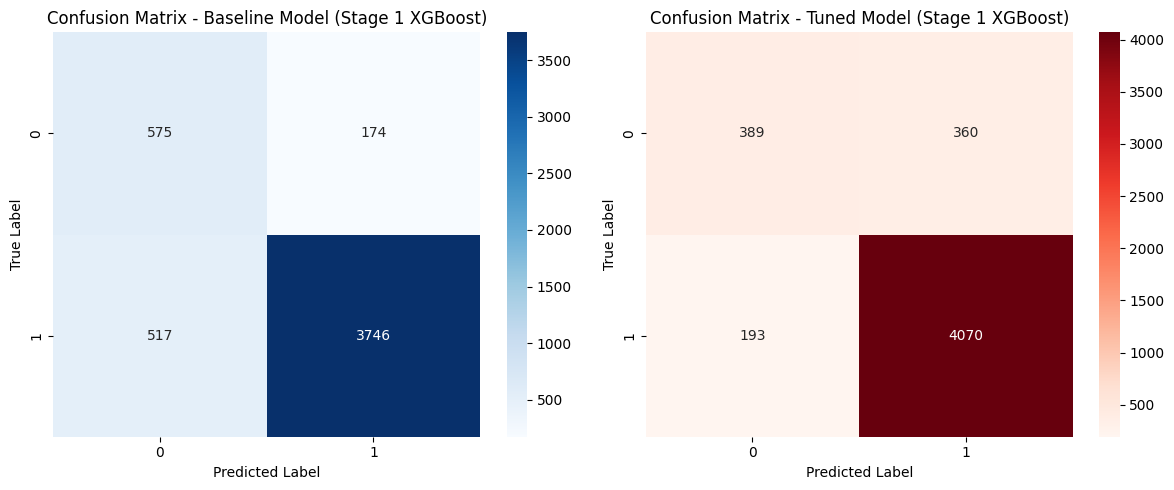

In [60]:
#Plot Heatmap for Confusion Matrix
plot_confusion_metrics_heatmap(baseline_xgb_model_stage1, best_tuned_xgb_stage1, "Stage 1 XGBoost")

**Explanation on Comparison:**

*   **Confusion Matrix**
    * True Positives increased significantly (3732 -> 4086) meaning the tuned model correctly **detects many more positive cases**.
    * False Negatives dropped sharply (577 -> 377) showing the tuned model misses far fewer positive cases
    * False Positives increase a little (172 -> 372), reflecting **slight loss in precision**
    * True Negatives decrease moderately (531 -> 177) consistent with the precision trade-off.
    * Overall **tuned model** becomes much **more sensitive** to **positive class** while sacrificing small amount of precision, a desired trade-off in classification tasks where detecting positive cases is critical.
*   **Metrics Comparison**
    * Accuracy (+0.03) Better correctness
    * Precision (-0.04) Slightly more false positives
    * Recall (+0.08) Better at catching positives
    * AUC (Same) Better at class separation
    * F1 Score (+0.02) Better balance of precision & recall
*   **Overall Interpretation**
    * Tuned XGBoost model is superior as it provides higher recall (less missed positives), higher accuracy, and higher F1 score.

# Stage 2 EDA, NN and XGBoost

##Pre-processing or EDA for Stage 2 data

**Stage 2: Pre-processing instructions**

- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.
- Choose how to engage with missing values, which can be done in one of two ways for this project:
  *   Impute the rows with appropriate values.
  *   Remove rows with missing values but ONLY in cases where rows with missing values are minimal: <2% of the overall data.



In [61]:
# File URL
file_url = "https://drive.google.com/uc?id=1vy1JFQZva3lhMJQV69C43AB1NTM4W-DZ"

In [62]:
# Start coding from here with Stage 2 dataset
main_data_stage2 = pd.read_csv(file_url)
main_data_stage2.shape

(25059, 18)

In [63]:
# Check unique and missing values for Stage 2 dataset
check_data(main_data_stage2)

Number of unique values in each column:
CentreName                     19
LearnerCode                 24877
BookingType                     2
LeadSource                      7
DiscountType                   11
DateofBirth                  4705
Gender                          2
Nationality                   151
HomeState                    2448
HomeCity                     5881
CourseLevel                     4
CourseName                    172
IsFirstIntake                   2
CompletedCourse                 2
ProgressionDegree            2616
ProgressionUniversity          40
AuthorisedAbsenceCount        190
UnauthorisedAbsenceCount      258
dtype: int64

Number of missing values in each column:
CentreName                      0
LearnerCode                     0
BookingType                     0
LeadSource                      0
DiscountType                17464
DateofBirth                     0
Gender                          0
Nationality                     0
HomeState            

In [64]:
# Convert Date of Birth to Age column for Stage 2 dataset
main_data_stage2 = preprocess_age(main_data_stage2)
main_data_stage2.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,Gender,Nationality,HomeState,HomeCity,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,Business and Law Pre-Masters,True,Yes,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN,27
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,Xi'an,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,BSc Biological Sciences,University of Aberdeen,93.0,5.0,27
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,Chengdu,International Year Two,Business Management and Finance International ...,False,Yes,MA Finance,University of Aberdeen,92.0,6.0,25
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,Business Management and Finance International ...,True,Yes,MA Business Management,University of Aberdeen,67.0,15.0,26
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,Xiamen,Pre-Masters,Business and Law Pre-Masters,True,Yes,MSc International Business Management,University of Aberdeen,NaN,NaN,29


In [65]:
#Remove columns not useful (LearnerCode), having high cardinality and having > 50% missing values
main_data_stage2 = main_data_stage2.drop(['LearnerCode', 'HomeState', 'HomeCity','DiscountType', 'ProgressionDegree'], axis=1)
main_data_stage2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   BookingType               25059 non-null  object 
 2   LeadSource                25059 non-null  object 
 3   Gender                    25059 non-null  object 
 4   Nationality               25059 non-null  object 
 5   CourseLevel               25059 non-null  object 
 6   CourseName                25059 non-null  object 
 7   IsFirstIntake             25059 non-null  bool   
 8   CompletedCourse           25059 non-null  object 
 9   ProgressionUniversity     25059 non-null  object 
 10  AuthorisedAbsenceCount    24851 non-null  float64
 11  UnauthorisedAbsenceCount  24851 non-null  float64
 12  Age                       25059 non-null  int64  
dtypes: bool(1), float64(2), int64(1), object(9)
memory usage: 2.3

In [66]:
#Remove rows where AuthorisedAbsenceCount is missing and UnauthorisedAbsenceCount is missing
main_data_stage2 = main_data_stage2.dropna(subset=['AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount'])
main_data_stage2.head()

,CentreName,BookingType,LeadSource,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age
1,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,University of Aberdeen,93.0,5.0,27
2,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,False,Yes,University of Aberdeen,92.0,6.0,25
3,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,True,Yes,University of Aberdeen,67.0,15.0,26
5,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,True,Yes,University of Aberdeen,67.0,3.0,25
6,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Foundation,Business; Economics; Accounting and Real Estat...,False,No,University of Aberdeen,29.0,18.0,23


In [67]:
# Perform encoding for Stage 2 dataset
main_data_stage2 = encode_data(main_data_stage2)
main_data_stage2.head()

,BookingType,Gender,CourseLevel,IsFirstIntake,CompletedCourse,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age,CentreName_ISC_Cardiff,CentreName_ISC_Dublin,...,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex,ProgressionUniversity_VU Amsterdam
1,0,0,0,False,1,93.0,5.0,27,False,False,...,False,True,False,False,False,False,False,False,False,False
2,0,0,2,False,1,92.0,6.0,25,False,False,...,False,True,False,False,False,False,False,False,False,False
3,0,0,2,True,1,67.0,15.0,26,False,False,...,False,True,False,False,False,False,False,False,False,False
5,0,0,2,True,1,67.0,3.0,25,False,False,...,False,True,False,False,False,False,False,False,False,False
6,0,0,0,False,0,29.0,18.0,23,False,False,...,False,True,False,False,False,False,False,False,False,False


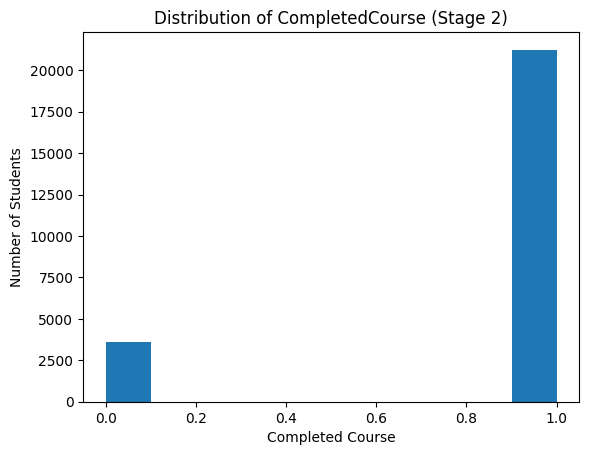

In [68]:
#Set CompletedCourse_Yes as target variable and check histogram for target variable to see if data is imbalanced
target_2 = main_data_stage2['CompletedCourse'].astype(int)
target_2.hist(grid=False)
plt.title('Distribution of CompletedCourse (Stage 2)')
plt.xlabel('Completed Course')
plt.ylabel('Number of Students')
plt.show()

X_2 = main_data_stage2.drop(['CompletedCourse'], axis=1)
y_2 = main_data_stage2['CompletedCourse']

**The findings from Pre-Processing the data:**
- Columns having **high cardinality (> 200 unique values)**: LearnerCode, HomeState, HomeCity, ProgressionDegree have been removed
- Columns having **>50% data missing**: DiscountType, HomeState, HomeCity, ProgressionDegree have been removed
- Remove rows where minimum missing values **less than 2%**: AuthorisedAbsenceCount (208 rows), UnauthorisedAbsenceCount (208 row)
- For **Gender** custom binary encoding is used, Male: 0 and Female: 1
- Since **CourseLevel** and **BookingType** had 4 and 2 unique values respectively, label encoding is executed. This would just reduce the complexity for the model training.
- For rest all categorical columns one-hot encoding is executed,
- **390** columns have been generated after encoding. This dataset with 390 columns will be used for model tuning.
- Looking at the histogram for **CompletedCourse** target variable it shows that the data is **imbalanced** - which means more students have completed the course than students who haven't completed. This will be taken into consideration while creating and tuning the model

##Neural Network - Baseline & Hyperparameter Tuning for Stage 2

### Fetch the results for baseline NN model for stage 2 data

In [69]:
# Split data for Stage 2 dataset
X_train_2, X_val_2, X_test_2, y_train_2, y_val_2, y_test_2 = split_data(X_2, target_2)

# Standardise the features with the StandardScaler.
X_train_2, X_val_2, X_test_2, scaler = standardize_data(X_train_2, X_val_2, X_test_2)

class_weights_2 = class_weights_for_imbalanced_data(y_train_2)

# Fetch the Neural Network Baseline model results
baseline_results_stage2 = neural_network_baseline_model(X_train_2, y_train_2, X_test_2, y_test_2, early_stop, class_weights_2)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7474 - loss: 0.5284 - val_accuracy: 0.8519 - val_loss: 0.3997
Epoch 2/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8549 - loss: 0.3821 - val_accuracy: 0.8427 - val_loss: 0.4036
Epoch 3/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8629 - loss: 0.3497 - val_accuracy: 0.8452 - val_loss: 0.3939
Epoch 4/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8625 - loss: 0.3369 - val_accuracy: 0.8581 - val_loss: 0.3646
Epoch 5/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8680 - loss: 0.3201 - val_accuracy: 0.8455 - val_loss: 0.4150
Epoch 6/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8689 - loss: 0.3159 - val_accuracy: 0.8455 - val_loss: 0.4036
Epoch 7/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8710 - loss: 0.3056 - val_accuracy: 0.8583 - val_loss: 0.3913
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


###Execute the hyperparameter tuning process using stage 2 data

In [70]:
best_tuned_model_stage2 = neural_network_hypertuned_model(X_train_2, y_train_2, X_test_2, y_test_2, early_stop, class_weights_2)

Reloading Tuner from tuner_results/student_dropout/tuner0.json
Search space summary
Default search space size: 7
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
activation_input (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
activation_hidden (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


504/504 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7864 - loss: 0.5664 - val_accuracy: 0.8682 - val_loss: 0.3532
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8453 - loss: 0.4641 - val_accuracy: 0.1380 - val_loss: 1.2660
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8415 - loss: 0.4619 - val_accuracy: 0.9028 - val_loss: 0.2563
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8512 - loss: 0.4648 - val_accuracy: 0.9067 - val_loss: 0.2468
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8424 - loss: 0.4861 - val_accuracy: 0.9039 - val_loss: 0.2607
Epoch 6/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8481 - loss: 0.4706 - val_accuracy: 0.8983 - val_loss: 0.3001
Epoch 7/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8505 - loss: 0.4666 - val_accuracy: 0.9022 - val_loss: 0.3035
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


##Compare the results & plots for Neural Network Baseline and Tuned Model (Stage 2)

In [75]:
#prints the hyperparameters for best tuned model
print("\n🔹 Hyperparameters for Best Tuned Model (Stage 2)")
for param, value in best_tuned_model_stage2['best_hyperparameters'].values.items():
  print(param, ":", value)


🔹 Hyperparameters for Best Tuned Model (Stage 2)
units_input : 192
activation_input : relu
units_hidden : 128
activation_hidden : tanh
dropout_rate : 0.2
optimizer : rmsprop
learning_rate : 0.01


In [76]:
comparison_df_stage2_nn = create_comparison_table(baseline_results_stage2, best_tuned_model_stage2)
print("\nComparison of Baseline and Tuned Neural Network Models (Stage 2)")
display(comparison_df_stage2_nn)


Comparison of Baseline and Tuned Neural Network Models (Stage 2)


,Metric,Baseline Model,Tuned Model
0,Accuracy,0.85,0.89
1,Precision,0.96,0.93
2,Recall,0.86,0.94
3,AUC,0.88,0.87
4,F1 Score,0.91,0.94


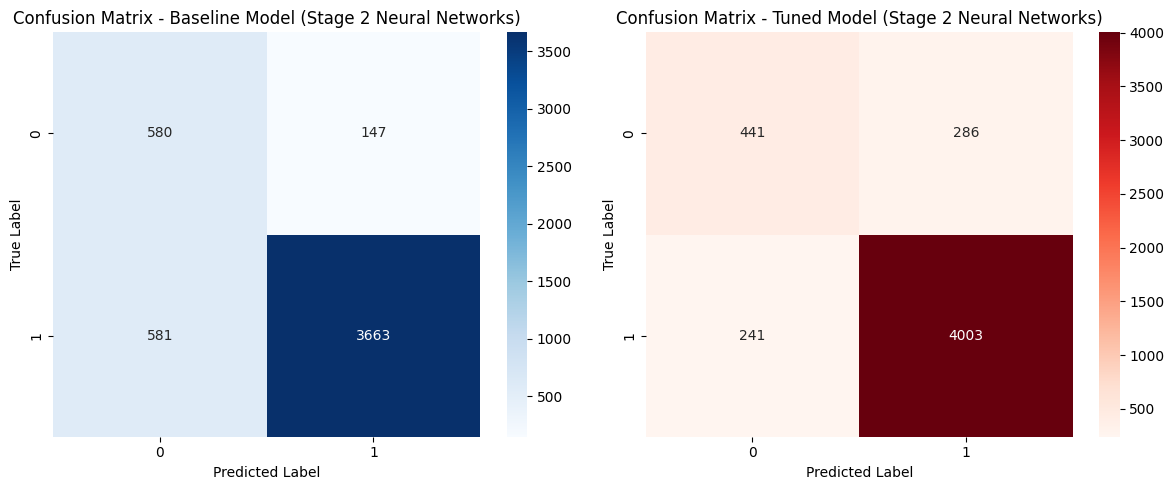

In [77]:
#Plot Heatmap for Confusion Matrix
plot_confusion_metrics_heatmap(baseline_results_stage2, best_tuned_model_stage2, "Stage 2 Neural Networks")

**Baseline Model (Stage 1)**
* True Negatives (TN): 552 → Correctly identified class 0
* False Positives (FP): 175 → Incorrectly predicted 1 for true class 0
* False Negatives (FN): 542 → Incorrectly predicted 0 for true class 1
* True Positives (TP): 3702 → Correctly identified class 1

**Tuned Model (Stage 1)**
* True Negatives (TN): 500 → Nearly same as baseline
* False Positives (FP): 227 → Nearly same as baseline
* False Negatives (FN): 344 → **Degraded**: missed positives
* True Positives (TP): 3900 → **Improved**: increase in finding positives

Both the models have almost same results, showing no change in the results.
Compare to Stage 1 the number of true positives have reduced, suggesting that the additional columns (AuthorisedAbsenceCount) and (UnauthorisedAbsenceCount) have an impact on the Course Completion.

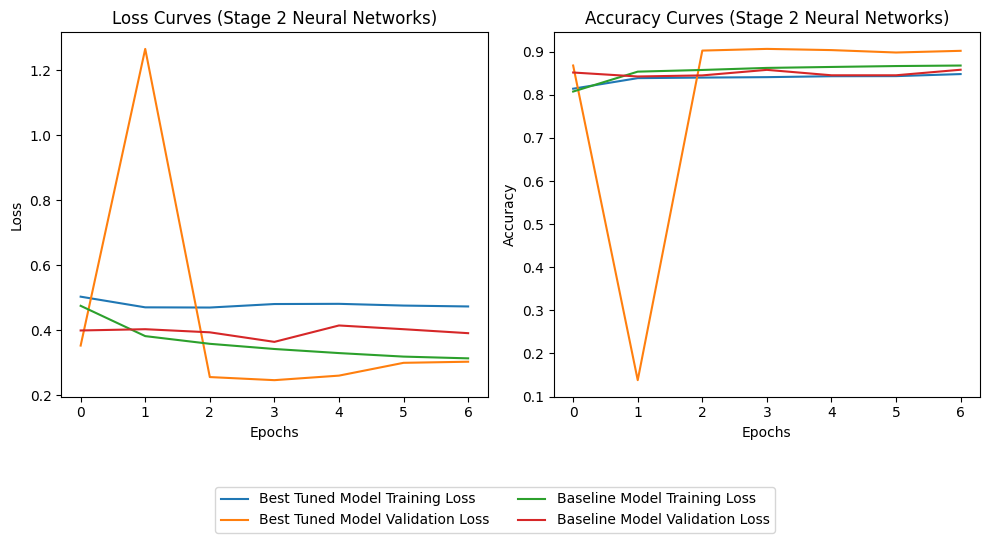

In [78]:
#Plot loss & accuracy curves for Neural Network Baseline and Tuned Model
plot_loss_accuracy_curves(baseline_results_stage2['baseline_history'].history, best_tuned_model_stage2['history_best_model'].history, "Stage 2 Neural Networks")

**Explanation on Comparison:**
*   **Loss Curves**    
    * **Baseline model**: Validation loss (Red) shows higher and then gets steady across epochs. Training loss (Green) starts higher and decreases slowing. Both of these patterns suggest less efficient learning.
    * **Tuned model**: Validation loss (Orange) shows fluctuations  and Training Loss (Blue) starts with lower loss and decreases steadily across epochs. These patterns suggest better generalization.
    * Tuned model is clearly learning more effectively, with both losses decreasing smoothly
    * Baseline model may be leading to slower convergence

*   **Accuracy Curves**    
    * **Baseline model**: Validation accuracy (Red) plateaus early and shows overall lowest accuracy compared to others. Training Accuracy (Green) improves slowly and plateaus at lower accuracy as well.
    * **Tuned model**: Training accuracy (Blue) achieves higher accuracy and faster (just 5 epochs) then rest and Validation accuracy consistently outperforms the baseline with stable accuracy.
    * Tuned model not only learns faster but also generalizes better to unseen data.
    * Baseline model struggles to reach competitive accuracy probably due to lack of regularization or limited capacity.


##Implement XGBoost and Hyperparameter Tuning for Stage 2

### Fetch results for baseline XGBoost model

In [82]:
baseline_xgb_model_stage2 = baseline_xgboost_model(X_train_2, y_train_2, X_test_2, y_test_2, X_val_2, y_val_2)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:04:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


###Fetch results for XGBoost tuned model and Print best hyperparameters

In [83]:
#Print Best parameters that resulted in highest avg score for roc_auc
best_tuned_xgb_stage2 = xgboost_hypertuned_model(X_train_2, y_train_2, X_test_2, y_test_2)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:04:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:04:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:04:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:04:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:04:48] WARNING: /w

In [84]:
#Print Best Parameters for XGBoost Tuned Model
print("🔹 Best Parameters for XGBoost Tuned Model (Stage 2):", best_tuned_xgb_stage2['best_tuned_xgb_parameters'])

🔹 Best Parameters for XGBoost Tuned Model (Stage 2): {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


##Compare results & plots for XGBoost Baseline and Tuned Model (Stage 2)

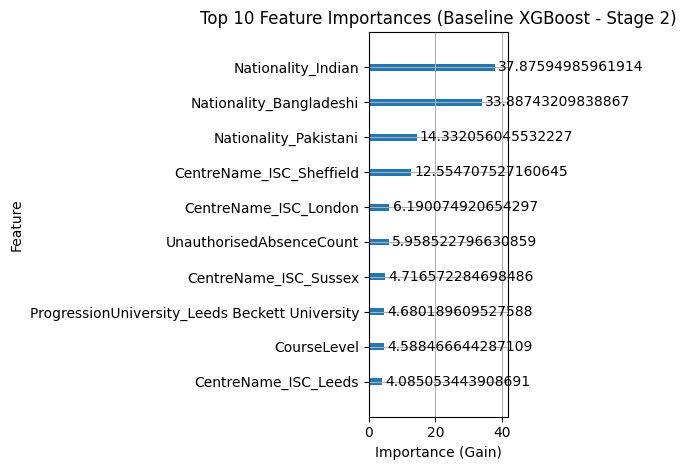

/tmp/ipython-input-1758773094.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


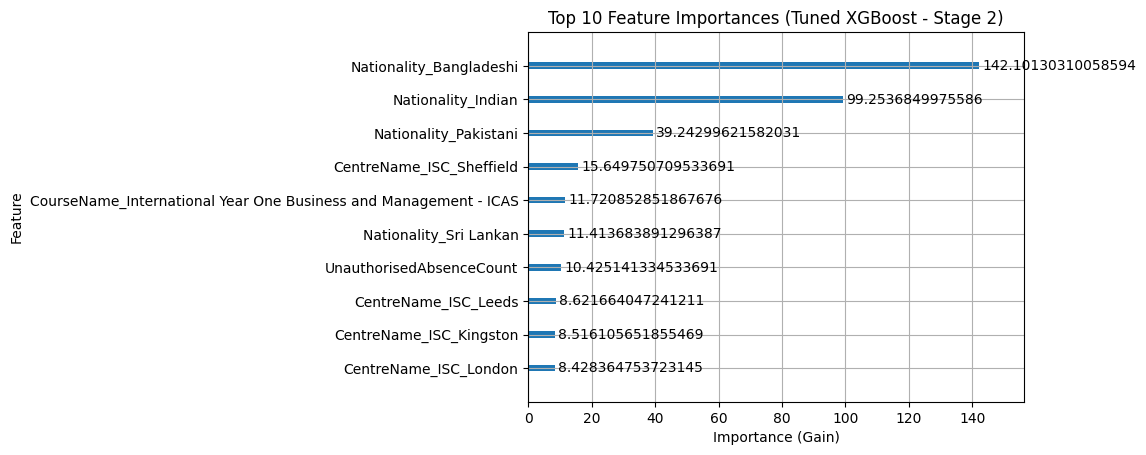

In [85]:
#Plot the feature importance with Stage 1 tuned XGBoost model
plot_xgboost_feature_importance(baseline_xgb_model_stage2['xgb_model'], title='Top 10 Feature Importances (Baseline XGBoost - Stage 2)')
plot_xgboost_feature_importance(best_tuned_xgb_stage2['best_tuned_xgb'], title='Top 10 Feature Importances (Tuned XGBoost - Stage 2)')


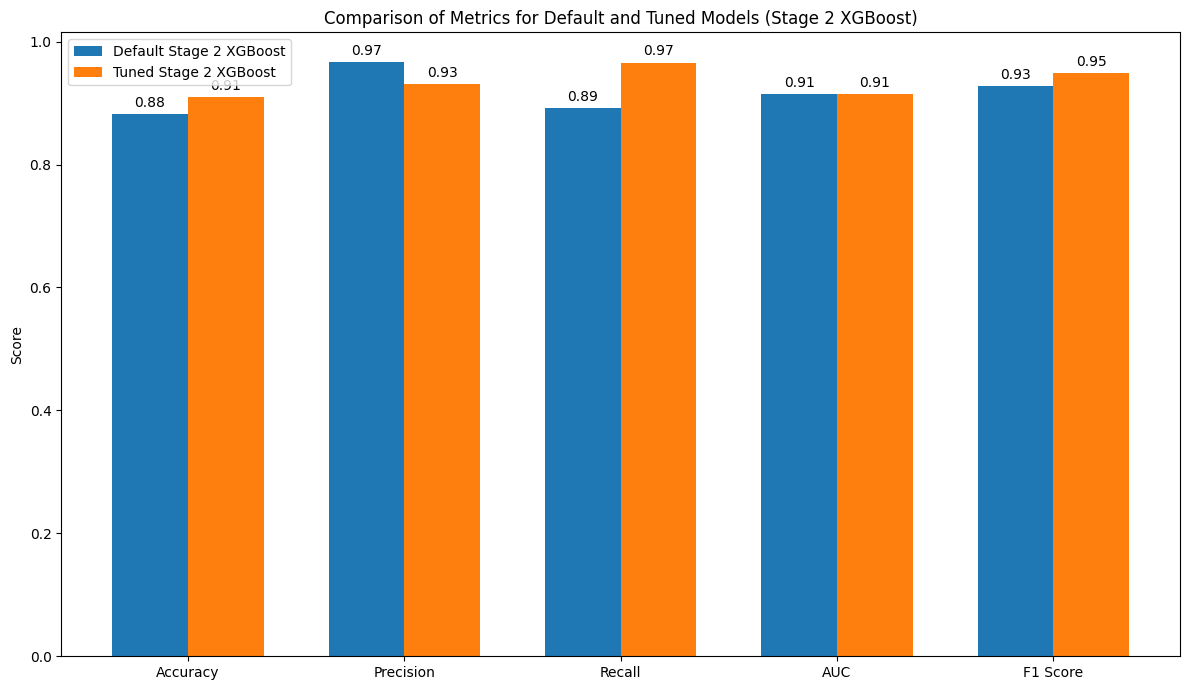

In [86]:
#Plot comparison metrics for Default & Tuned Model (XGBoost) and Heatmap for Confusion Matrix
plot_model_comparison_results(baseline_xgb_model_stage2, best_tuned_xgb_stage2, "Stage 2 XGBoost")

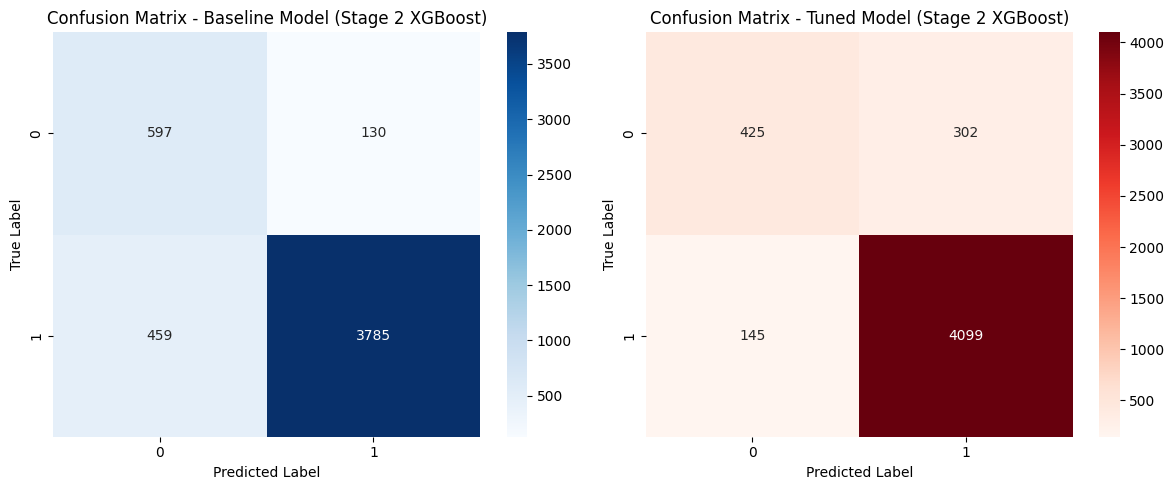

In [87]:
#Plot Heatmap for Confusion Matrix
plot_confusion_metrics_heatmap(baseline_xgb_model_stage2, best_tuned_xgb_stage2, "Stage 2 XGBoost")

**Explanation on Comparison:**

*   **Confusion Matrix**
    * True Positives increased significantly (3768 -> 4097) meaning the tuned model correctly **detects many more positive cases**.
    * False Negatives dropped sharply (476 -> 147) showing the tuned model misses far fewer positive cases
    * False Positives increase a little (136 -> 307), reflecting **slight loss in precision**
    * True Negatives decrease moderately (591 -> 420) consistent with the precision trade-off.
    * Overall **tuned model** becomes much **more sensitive** to **positive class** while sacrificing small amount of precision, a desired trade-off in classification tasks where detecting positive cases is critical.
*   **Metrics Comparison**
    * Accuracy (+0.04) Better correctness
    * Precision (-0.03) Slightly more false positives
    * Recall (+0.08) Better at catching positives
    * AUC (+0.01) Slightly better at class separation
    * F1 Score (+0.03) Better balance of precision & recall
*   **Overall Interpretation**
    * Tuned XGBoost model is superior as it provides higher recall (less missed positives), higher accuracy, better AUC, higher F1 score.



#Compare results of NN, XGBoost for Stage 1 and Stage 2

In [88]:
data = {
    'Model': ['NN', 'NN', 'NN', 'NN', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost',],
    'Tuning': ['Base', 'Tuned', 'Base', 'Tuned', 'Base', 'Tuned', 'Base', 'Tuned'],
    'Stage': ['Stage 1', 'Stage 1', 'Stage 2', 'Stage 2', 'Stage 1', 'Stage 1', 'Stage 2', 'Stage 2'],
    'Accuracy': [round(baseline_results_stage1['accuracy'], 2), round(best_tuned_model_stage1['accuracy'], 2),
                 round(baseline_results_stage2['accuracy'], 2), round(best_tuned_model_stage2['accuracy'], 2),
                 round(baseline_xgb_model_stage1['accuracy'], 2), round(best_tuned_xgb_stage1['accuracy'], 2),
                 round(baseline_xgb_model_stage2['accuracy'], 2), round(best_tuned_xgb_stage2['accuracy'], 2)],
    'Precision': [round(baseline_results_stage1['precision'], 2), round(best_tuned_model_stage1['precision'], 2),
                  round(baseline_results_stage2['precision'], 2), round(best_tuned_model_stage2['precision'], 2),
                  round(baseline_xgb_model_stage1['precision'], 2), round(best_tuned_xgb_stage1['precision'], 2),
                  round(baseline_xgb_model_stage2['precision'], 2), round(best_tuned_xgb_stage2['precision'], 2)],
    'Recall': [round(baseline_results_stage1['recall'], 2), round(best_tuned_model_stage1['recall'], 2),
               round(baseline_results_stage2['recall'], 2), round(best_tuned_model_stage2['recall'], 2),
               round(baseline_xgb_model_stage1['recall'], 2), round(best_tuned_xgb_stage1['recall'], 2),
               round(baseline_xgb_model_stage2['recall'], 2), round(best_tuned_xgb_stage2['recall'], 2)],
    'AUC': [round(baseline_results_stage1['auc'], 2), round(best_tuned_model_stage1['auc'], 2),
            round(baseline_results_stage2['auc'], 2), round(best_tuned_model_stage2['auc'], 2),
            round(baseline_xgb_model_stage1['auc'], 2), round(best_tuned_xgb_stage1['auc'], 2),
            round(baseline_xgb_model_stage2['auc'], 2), round(best_tuned_xgb_stage2['auc'], 2)],
    'F1 Score': [round(baseline_results_stage1['f1_score'], 2), round(best_tuned_model_stage1['f1_score'], 2),
                 round(baseline_results_stage2['f1_score'], 2), round(best_tuned_model_stage2['f1_score'], 2),
                 round(baseline_xgb_model_stage1['f1_score'], 2), round(best_tuned_xgb_stage1['f1_score'], 2),
                 round(baseline_xgb_model_stage2['f1_score'], 2), round(best_tuned_xgb_stage2['f1_score'], 2)]
}

results_df = pd.DataFrame(data)

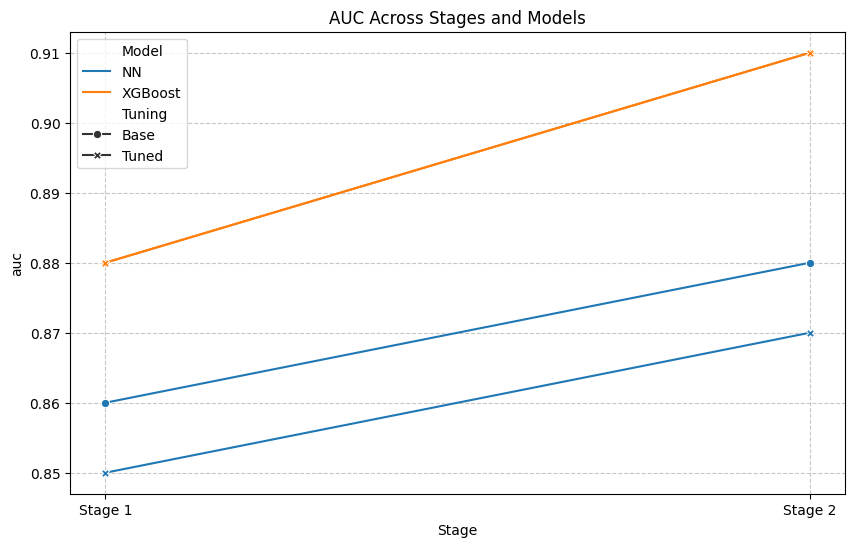

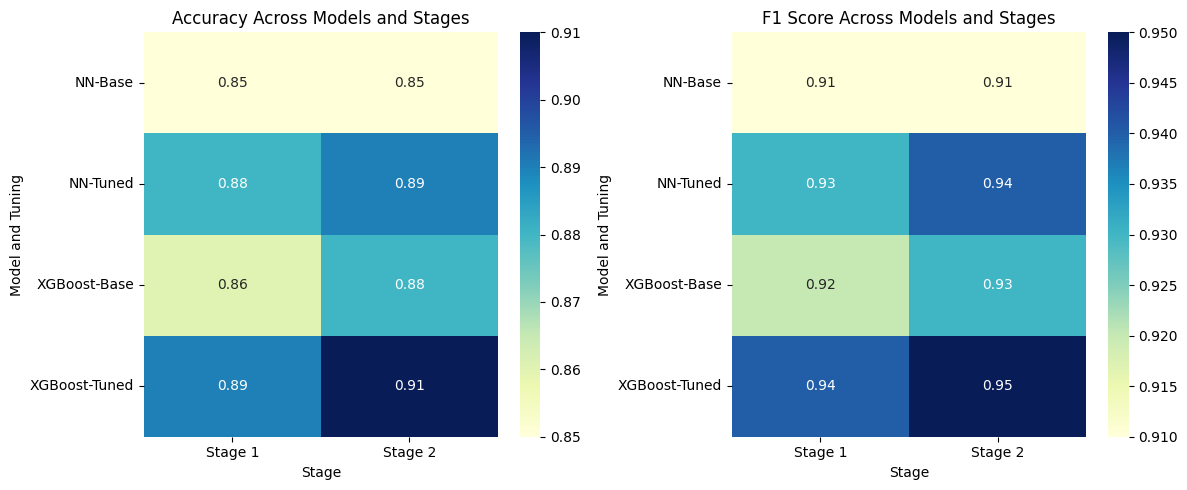

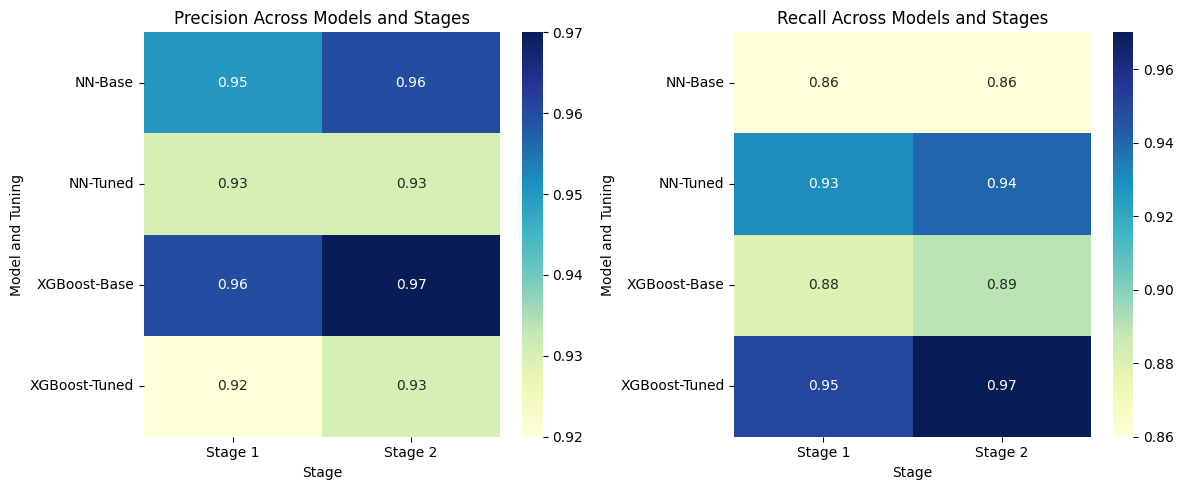

In [89]:
plt.figure(figsize=(10,6))
sns.lineplot(data=results_df, x='Stage', y='AUC',
             hue='Model', style='Tuning', markers=True, dashes=False)
plt.title('AUC Across Stages and Models')
plt.xlabel('Stage')
plt.ylabel('auc')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

metrics_to_plot = ['Accuracy', 'F1 Score'] # Select three metrics for the row
fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 5)) # Create a figure with a row of subplots

for i, metric in enumerate(metrics_to_plot):
    pivot = results_df.pivot_table(index=['Model', 'Tuning'], columns='Stage', values=metric)
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".2f", ax=axes[i]) # Plot on the corresponding subplot
    axes[i].set_title(f'{metric} Across Models and Stages') # Set title for each subplot
    axes[i].set_xlabel('Stage')
    axes[i].set_ylabel('Model and Tuning')

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

metrics_to_plot = ['Precision', 'Recall'] # Select three metrics for the row
fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 5)) # Create a figure with a row of subplots

for i, metric in enumerate(metrics_to_plot):
    pivot = results_df.pivot_table(index=['Model', 'Tuning'], columns='Stage', values=metric)
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".2f", ax=axes[i]) # Plot on the corresponding subplot
    axes[i].set_title(f'{metric} Across Models and Stages') # Set title for each subplot
    axes[i].set_xlabel('Stage')
    axes[i].set_ylabel('Model and Tuning')

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

# Stage 3 EDA, NN and XGBoost

##Pre-processing or EDA for Stage 3 data

**Stage 3: Pre-processing instructions**

- Remove any columns not useful in the analysis (LearnerCode).
- Remove columns with high cardinality (use >200 unique values, as a guideline for this data set).
- Remove columns with >50% data missing.
- Perform ordinal encoding for ordinal data.
- Perform one-hot encoding for all other categorical data.
- Choose how to engage with rows that have missing values, which can be done in one of two ways for this project:
  *   Impute the rows with appropriate values.
  *   Remove rows with missing values but ONLY in cases where rows with missing values are minimal: <2% of the overall data.






In [90]:
# File URL
file_url = "https://drive.google.com/uc?id=18oyu-RQotQN6jaibsLBoPdqQJbj_cV2-"


In [91]:
# Start coding from here with Stage 3 dataset
main_data_stage3 = pd.read_csv(file_url)
main_data_stage3.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,DateofBirth,Gender,Nationality,HomeState,HomeCity,...,CourseName,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,13/01/1998,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,12/2/1998,Male,Chinese,NaN,Xi'an,...,Life Sciences Undergraduate Foundation Programme,False,Yes,7.0,7.0,0.0,BSc Biological Sciences,University of Aberdeen,93.0,5.0
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,7/4/2000,Male,Chinese,NaN,Chengdu,...,Business Management and Finance International ...,False,Yes,8.0,8.0,0.0,MA Finance,University of Aberdeen,92.0,6.0
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,18/05/1999,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,...,Business Management and Finance International ...,True,Yes,8.0,8.0,0.0,MA Business Management,University of Aberdeen,67.0,15.0
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,19/04/1996,Male,Chinese,NaN,Xiamen,...,Business and Law Pre-Masters,True,Yes,4.0,4.0,0.0,MSc International Business Management,University of Aberdeen,NaN,NaN


In [92]:
# Check unique and missing values for Stage 3 dataset
check_data(main_data_stage3)

Number of unique values in each column:
CentreName                     19
LearnerCode                 24877
BookingType                     2
LeadSource                      7
DiscountType                   11
DateofBirth                  4705
Gender                          2
Nationality                   151
HomeState                    2448
HomeCity                     5881
CourseLevel                     4
CourseName                    172
IsFirstIntake                   2
CompletedCourse                 2
AssessedModules                12
PassedModules                  12
FailedModules                  11
ProgressionDegree            2616
ProgressionUniversity          40
AuthorisedAbsenceCount        190
UnauthorisedAbsenceCount      258
dtype: int64

Number of missing values in each column:
CentreName                      0
LearnerCode                     0
BookingType                     0
LeadSource                      0
DiscountType                17464
DateofBirth          

In [93]:
# Convert Date of Birth to Age column for Stage 3 dataset
main_data_stage3 = preprocess_age(main_data_stage3)
main_data_stage3.head()

,CentreName,LearnerCode,BookingType,LeadSource,DiscountType,Gender,Nationality,HomeState,HomeCity,CourseLevel,...,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,ProgressionDegree,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age
0,ISC_Aberdeen,2284932,Agent,Standard Agent Booking,NaN,Male,Chinese,Jianye District; Jiangsu Province,Nanjing,Pre-Masters,...,True,Yes,4.0,4.0,0.0,Msc Econ Accounting and Investment Management,University of Aberdeen,NaN,NaN,27
1,ISC_Aberdeen,2399500,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,Xi'an,Foundation,...,False,Yes,7.0,7.0,0.0,BSc Biological Sciences,University of Aberdeen,93.0,5.0,27
2,ISC_Aberdeen,2424946,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,Chengdu,International Year Two,...,False,Yes,8.0,8.0,0.0,MA Finance,University of Aberdeen,92.0,6.0,25
3,ISC_Aberdeen,2426583,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,LIUYANG CITY ;CHANGSHA,International Year Two,...,True,Yes,8.0,8.0,0.0,MA Business Management,University of Aberdeen,67.0,15.0,26
4,ISC_Aberdeen,2434674,Agent,Standard Agent Booking,NaN,Male,Chinese,NaN,Xiamen,Pre-Masters,...,True,Yes,4.0,4.0,0.0,MSc International Business Management,University of Aberdeen,NaN,NaN,29


In [94]:
#Remove columns not useful (LearnerCode), having high cardinality and having > 50% missing values
main_data_stage3 = main_data_stage3.drop(['LearnerCode', 'HomeState', 'HomeCity', 'ProgressionDegree','DiscountType'], axis=1)
main_data_stage3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25059 entries, 0 to 25058
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CentreName                25059 non-null  object 
 1   BookingType               25059 non-null  object 
 2   LeadSource                25059 non-null  object 
 3   Gender                    25059 non-null  object 
 4   Nationality               25059 non-null  object 
 5   CourseLevel               25059 non-null  object 
 6   CourseName                25059 non-null  object 
 7   IsFirstIntake             25059 non-null  bool   
 8   CompletedCourse           25059 non-null  object 
 9   AssessedModules           22828 non-null  float64
 10  PassedModules             22828 non-null  float64
 11  FailedModules             22828 non-null  float64
 12  ProgressionUniversity     25059 non-null  object 
 13  AuthorisedAbsenceCount    24851 non-null  float64
 14  Unauth

In [95]:
#Remove rows where AuthorisedAbsenceCount is missing and UnauthorisedAbsenceCount is missing
main_data_stage3 = main_data_stage3.dropna(subset=['AuthorisedAbsenceCount', 'UnauthorisedAbsenceCount'])
main_data_stage3.head()

,CentreName,BookingType,LeadSource,Gender,Nationality,CourseLevel,CourseName,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,ProgressionUniversity,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,Age
1,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Foundation,Life Sciences Undergraduate Foundation Programme,False,Yes,7.0,7.0,0.0,University of Aberdeen,93.0,5.0,27
2,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,False,Yes,8.0,8.0,0.0,University of Aberdeen,92.0,6.0,25
3,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,True,Yes,8.0,8.0,0.0,University of Aberdeen,67.0,15.0,26
5,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,International Year Two,Business Management and Finance International ...,True,Yes,8.0,8.0,0.0,University of Aberdeen,67.0,3.0,25
6,ISC_Aberdeen,Agent,Standard Agent Booking,Male,Chinese,Foundation,Business; Economics; Accounting and Real Estat...,False,No,NaN,NaN,NaN,University of Aberdeen,29.0,18.0,23


In [96]:
# Perform encoding for Stage 3 dataset
main_data_stage3 = encode_data(main_data_stage3)
main_data_stage3.head()

,BookingType,Gender,CourseLevel,IsFirstIntake,CompletedCourse,AssessedModules,PassedModules,FailedModules,AuthorisedAbsenceCount,UnauthorisedAbsenceCount,...,ProgressionUniversity_University College Dublin,ProgressionUniversity_University of Aberdeen,ProgressionUniversity_University of Huddersfield,ProgressionUniversity_University of Leeds,ProgressionUniversity_University of Lincoln,ProgressionUniversity_University of Sheffield International College,ProgressionUniversity_University of Strathclyde,ProgressionUniversity_University of Surrey,ProgressionUniversity_University of Sussex,ProgressionUniversity_VU Amsterdam
1,0,0,0,False,1,7.0,7.0,0.0,93.0,5.0,...,False,True,False,False,False,False,False,False,False,False
2,0,0,2,False,1,8.0,8.0,0.0,92.0,6.0,...,False,True,False,False,False,False,False,False,False,False
3,0,0,2,True,1,8.0,8.0,0.0,67.0,15.0,...,False,True,False,False,False,False,False,False,False,False
5,0,0,2,True,1,8.0,8.0,0.0,67.0,3.0,...,False,True,False,False,False,False,False,False,False,False
6,0,0,0,False,0,NaN,NaN,NaN,29.0,18.0,...,False,True,False,False,False,False,False,False,False,False


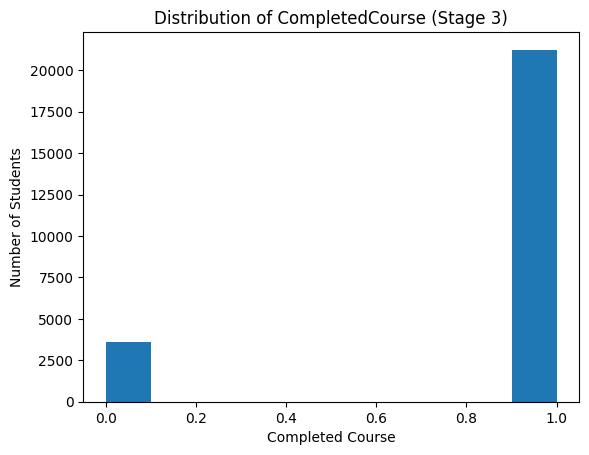

In [97]:
#Set CompletedCourse_Yes as target variable and check histogram for target variable to see if data is imbalanced
target_3 = main_data_stage3['CompletedCourse'].astype(int)
target_3.hist(grid=False)
plt.title('Distribution of CompletedCourse (Stage 3)')
plt.xlabel('Completed Course')
plt.ylabel('Number of Students')
plt.show()

In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, chi2_contingency

def classify_missingness(df, target, corr_threshold=0.2, p_threshold=0.05):
    """
    Diagnose missingness mechanism for each variable in a dataset.
    Classifies as MCAR, MAR, or MNAR based on relationships with features and target.

    Parameters
    ----------
    df : pd.DataFrame
        The dataset.
    target : str
        Name of target column (e.g., 'dropout').
    corr_threshold : float, default=0.2
        Correlation magnitude above which we consider a relationship meaningful.
    p_threshold : float, default=0.05
        Significance threshold for hypothesis testing.
    """

    df = df.copy()

    # 1️⃣ Create missingness indicators
    missing_cols = [col for col in df.columns if df[col].isna().any()]
    for col in missing_cols:
        df[f'{col}_missing'] = df[col].isna().astype(int)
    miss_indicators = [c for c in df.columns if c.endswith('_missing')]

    print(f"\n🔍 Created {len(miss_indicators)} missing indicators:")
    print(miss_indicators, "\n")

    # 2️⃣ Correlation heatmap
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[numeric_cols].corr().loc[miss_indicators, numeric_cols],
                cmap='coolwarm', center=0, annot=False)
    plt.title("Correlation of Missingness Indicators with Numeric Variables")
    plt.show()

    # 3️⃣ Statistical tests with target
    results = []
    for col in miss_indicators:
        try:
            if np.issubdtype(df[target].dtype, np.number):
                # Numeric or binary numeric target
                r, p = pearsonr(df[col], df[target])
                test = "Pearson"
            else:
                # Categorical target
                cont = pd.crosstab(df[col], df[target])
                chi2, p, _, _ = chi2_contingency(cont)
                r = np.nan
                test = "Chi-square"

            results.append((col, r, p, test))
        except Exception as e:
            results.append((col, np.nan, np.nan, f"Error: {e}"))

    res_df = pd.DataFrame(results, columns=['Indicator', 'Corr_with_Target', 'p_value', 'Test'])

    # 4️⃣ Determine relationships with other observed vars
    corr_matrix = df[numeric_cols].corr().abs()
    avg_corr_with_features = []
    for ind in miss_indicators:
        if ind in corr_matrix.index:
            avg_corr = corr_matrix.loc[ind].drop(miss_indicators, errors='ignore').mean()
        else:
            avg_corr = np.nan
        avg_corr_with_features.append(avg_corr)

    res_df["AvgCorr_with_Features"] = avg_corr_with_features

    # 5️⃣ Classification logic
    classifications = []
    for _, row in res_df.iterrows():
        if (row["p_value"] > p_threshold) and (row["AvgCorr_with_Features"] < corr_threshold):
            classifications.append("MCAR (Completely at Random)")
        elif (row["p_value"] <= p_threshold):
            classifications.append("MNAR / Informative (depends on target)")
        elif (row["AvgCorr_with_Features"] >= corr_threshold):
            classifications.append("MAR (depends on other features)")
        else:
            classifications.append("Unclear")
    res_df["Likely_Missingness_Type"] = classifications

    # 6️⃣ Display summary
    print("\n📊 Missingness Diagnosis Summary:")

    return res_df



🔍 Created 3 missing indicators:
['AssessedModules_missing', 'PassedModules_missing', 'FailedModules_missing'] 



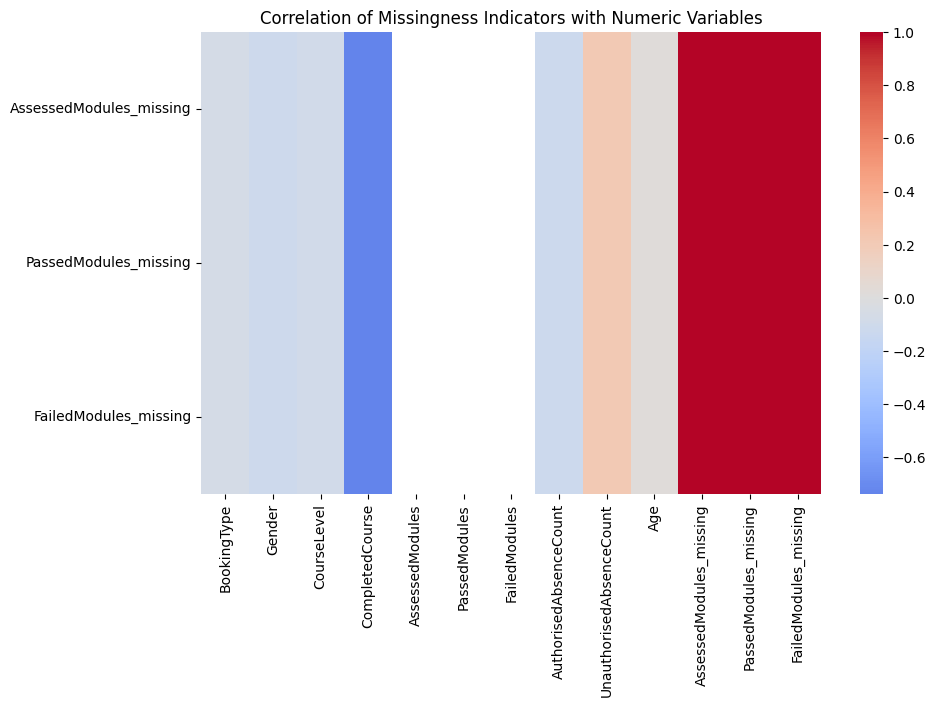


📊 Missingness Diagnosis Summary:


,Indicator,Corr_with_Target,p_value,Test,AvgCorr_with_Features,Likely_Missingness_Type
0,AssessedModules_missing,-0.737462,0.0,Pearson,0.194138,MNAR / Informative (depends on target)
1,PassedModules_missing,-0.737462,0.0,Pearson,0.194138,MNAR / Informative (depends on target)
2,FailedModules_missing,-0.737462,0.0,Pearson,0.194138,MNAR / Informative (depends on target)


In [99]:
classify_missingness(main_data_stage3, 'CompletedCourse')

In [100]:

stage3_columns=['AssessedModules', 'PassedModules', 'FailedModules']
#Create missingness indicators for Stage 3 columns
for col in stage3_columns:
   main_data_stage3[f'{col}_missing'] = main_data_stage3[col].isna().astype(int)

#impute missing values to 0
main_data_stage3[stage3_columns] = main_data_stage3[stage3_columns].fillna(0)

main_data_stage3.head()

X_3 = main_data_stage3.drop(['CompletedCourse'], axis=1)
y_3 = main_data_stage3['CompletedCourse']

**The findings from Pre-Processing the data:**
- Columns having **high cardinality (> 200 unique values)**: LearnerCode, HomeState, HomeCity, ProgressionDegree have been removed
- Columns having **>50% data missing**: DiscountType, HomeState, HomeCity, ProgressionDegree have been removed
- For **Gender** custom binary encoding is used, Male: 0 and Female: 1
- Since **CourseLevel** and **BookingType** had 4 and 2 unique values respectively, label encoding is executed. This would just reduce the complexity for the model training.
- For rest all categorical columns one-hot encoding is executed,
- 393 columns have been generated after encoding. This dataset with **396 columns** will be used for model tuning (3 more columns added due to missing data).
- Looking at the histogram for **CompletedCourse** target variable it shows that the data is **imbalanced** - which means more students have completed the course than students who haven't completed. This will be taken into consideration while creating and tuning the model
- Remove rows where minimum missing values **less than 2%**: AuthorisedAbsenceCount (208 rows), UnauthorisedAbsenceCount (208 row)
- For missing data in AssessedModules, PassedModules and FailedModules columns which was almost **10%** a **Missingness-Target Correlation Analysis** was carried out.
  * assessedmodules_missing, passedmodules_missing and failedmodules_missing : missingness indicators were created. Each indicator takes value 1 if values is missing and 0 otherwise.
  * These indicators were then statistically tested for association with target variable (CompletedCourse)
  * The goal was to determine MCAR, MAR and MNAR. All 3 variables were classified as **MNAR (Missing Not at Random)**.
  * Hence the strategy used for imputation: **Keeping missingness indicators**, **imputing **stage 3 **values** and **keeping both imputed values and missingness flag in predictive model**.
  * This approach preserves both missing data and statistical relationships.


##Neural Network - Baseline & Hyperparameter Tuning for Stage 3

### Fetch the results for baseline NN model for stage 3 data

In [101]:
# Split data for Stage 3 dataset
X_train_3, X_val_3, X_test_3, y_train_3, y_val_3, y_test_3 = split_data(X_3, target_3)

# Standardise the features with the StandardScaler.
X_train_3, X_val_3, X_test_3, scaler = standardize_data(X_train_3, X_val_3, X_test_3)

class_weights_3 = class_weights_for_imbalanced_data(y_train_3)

# Fetch the Neural Network Baseline model results
baseline_results_stage3 = neural_network_baseline_model(X_train_3, y_train_3, X_test_3, y_test_3, early_stop, class_weights_3)

Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8001 - loss: 0.3371 - val_accuracy: 0.9626 - val_loss: 0.1091
Epoch 2/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9736 - loss: 0.0651 - val_accuracy: 0.9782 - val_loss: 0.0643
Epoch 3/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9827 - loss: 0.0416 - val_accuracy: 0.9721 - val_loss: 0.0858
Epoch 4/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9858 - loss: 0.0338 - val_accuracy: 0.9790 - val_loss: 0.0629
Epoch 5/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9882 - loss: 0.0272 - val_accuracy: 0.9760 - val_loss: 0.0813
Epoch 6/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9866 - loss: 0.0300 - val_accuracy: 0.9844 - val_loss: 0.0569
Epoch 7/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9898 - loss: 0.0255 - val_accuracy: 0.9852 - val_loss: 0.0538
Epoch 8/20
448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9910 - loss: 0.0212 - val_accuracy: 0.9827 - val_

###Execute the hyperparameter tuning process using stage 3 data

In [102]:
best_tuned_model_stage3 = neural_network_hypertuned_model(X_train_3, y_train_3, X_test_3, y_test_3, early_stop, class_weights_3)

Reloading Tuner from tuner_results/student_dropout/tuner0.json
Search space summary
Default search space size: 7
units_input (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': 'linear'}
activation_input (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
units_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': 'linear'}
activation_hidden (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'rmsprop'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9260 - loss: 0.2447 - val_accuracy: 0.9648 - val_loss: 0.0911
Epoch 2/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9727 - loss: 0.0916 - val_accuracy: 0.9860 - val_loss: 0.0432
Epoch 3/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9764 - loss: 0.0942 - val_accuracy: 0.9777 - val_loss: 0.0709
Epoch 4/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9782 - loss: 0.0844 - val_accuracy: 0.9743 - val_loss: 0.0779
Epoch 5/20
504/504 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9803 - loss: 0.0978 - val_accuracy: 0.9698 - val_loss: 0.1482
156/156 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


##Compare the results & plots for Neural Network Baseline and Tuned Model (Stage 3)

In [103]:
#prints the hyperparameters for best tuned model
print("\n🔹 Hyperparameters for Best Tuned Model (Stage 3)")
for param, value in best_tuned_model_stage3['best_hyperparameters'].values.items():
  print(param, ":", value)


🔹 Hyperparameters for Best Tuned Model (Stage 3)
units_input : 192
activation_input : relu
units_hidden : 128
activation_hidden : tanh
dropout_rate : 0.2
optimizer : rmsprop
learning_rate : 0.01


In [104]:
comparison_df_stage3_nn = create_comparison_table(baseline_results_stage3, best_tuned_model_stage3)
print("\nComparison of Baseline and Tuned Neural Network Models (Stage 3)")
display(comparison_df_stage3_nn)


Comparison of Baseline and Tuned Neural Network Models (Stage 3)


,Metric,Baseline Model,Tuned Model
0,Accuracy,0.98,0.98
1,Precision,0.99,0.99
2,Recall,0.99,0.99
3,AUC,1.00,1.00
4,F1 Score,0.99,0.99


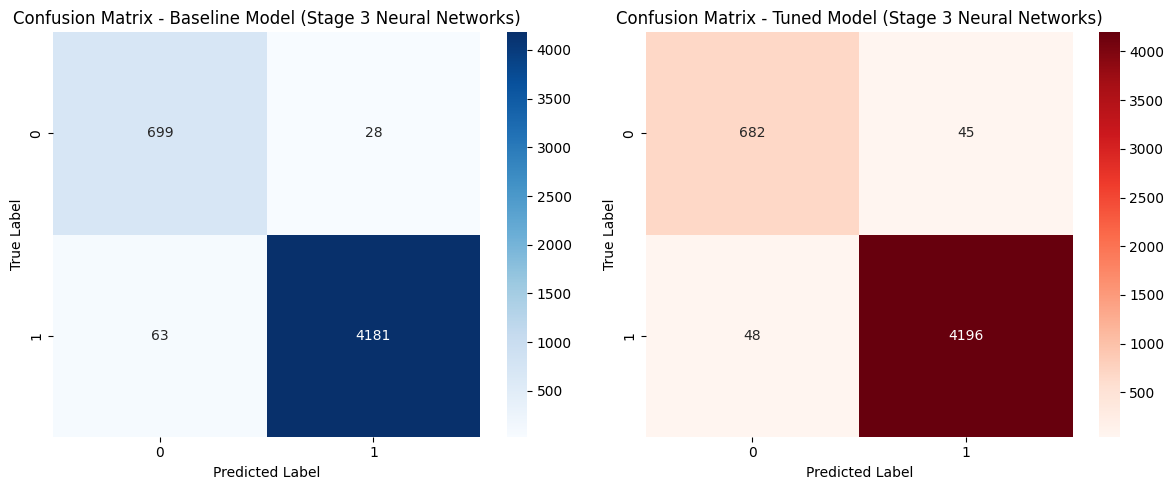

In [105]:
#Plot Heatmap for Confusion Matrix
plot_confusion_metrics_heatmap(baseline_results_stage3, best_tuned_model_stage3, "Stage 3 Neural Networks")

**Baseline Model (Stage 1)**
* True Negatives (TN): 689 → Correctly identified class 0
* False Positives (FP): 38 → Incorrectly predicted 1 for true class 0
* False Negatives (FN): 47 → Incorrectly predicted 0 for true class 1
* True Positives (TP): 4197 → Correctly identified class 1

**Tuned Model (Stage 1)**
* True Negatives (TN): 683 → Slightly fewer than baseline
* False Positives (FP): 44 → Slightly more than baseline
* False Negatives (FN): 66 → **Improved**: fewer missed positives
* True Positives (TP): 4178 → **Improved**: more correctly detected positives

Tuned model correctly identifies more true positives and reduces false negatives compared to the baseline, showing improved sensitivity at the small cost of slightly more false positives


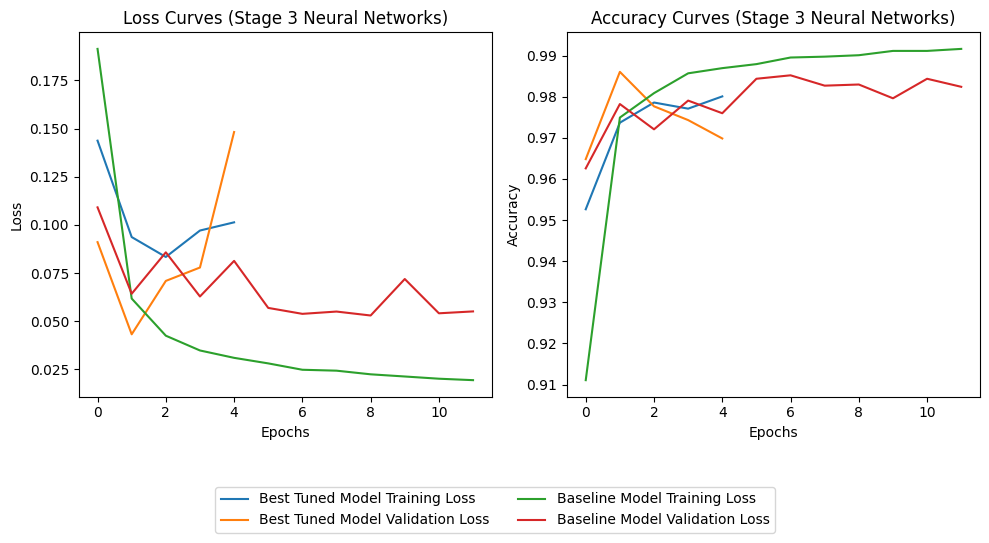

In [106]:
#Plot loss & accuracy curves for Neural Network Baseline and Tuned Model
plot_loss_accuracy_curves(baseline_results_stage3['baseline_history'].history, best_tuned_model_stage3['history_best_model'].history, "Stage 3 Neural Networks")

**Explanation on Comparison:**    
*   **Loss Curves**    
    * **Baseline model**: Training loss (green) starts higher and decreases slowly, whereas validation loss (red) remains higher and achieves a plateau.
    * **Tuned model**: Validation loss (orange) starts low, training loss (blue) decreases indicating the model is learning efficiently.
    * Tuned model has lower loss both in training and validation showing that hyperparameter tuning improved predictive accuracy and reduced overfitting.
    * Baseline model struggles suggesting it's less robust.

*   **Accuracy Curves**    
    * **Baseline model**: Validation accuracy (red) starts lower and never reaches tuned model's performance. Training accuracy (green) also is lower and improves slowly.
    * **Tuned model**: Training accuracy (blue) starts high and reaches near-perfect accuracy. Validation accuracy (orange) also starts high and stable, following training accuracy.
    * Tuned model achieves consistently higher accuracy, both in training and validation indicating better learning.
    * Baseline model shows signs of underfitting with lower accuracy and more variance across epochs.



##Implement XGBoost and Hyperparameter Tuning for Stage 3

### Fetch results for baseline XGBoost model

In [107]:
baseline_xgb_model_stage3 = baseline_xgboost_model(X_train_3, y_train_3, X_test_3, y_test_3,X_val_3,y_val_3)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:09:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


###Fetch results for XGBoost tuned model and Print best hyperparameters

In [108]:
#Print Best parameters that resulted in highest avg score for roc_auc
best_tuned_xgb_stage3 = xgboost_hypertuned_model(X_train_3, y_train_3, X_test_3, y_test_3)

print("🔹 Best Parameters:", best_tuned_xgb_stage3['best_tuned_xgb_parameters'])

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:09:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:09:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:09:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:09:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:09:13] WARNING: /w

🔹 Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}


##Compare results & plots for XGBoost Baseline and Tuned Model (Stage 3)

/tmp/ipython-input-1758773094.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


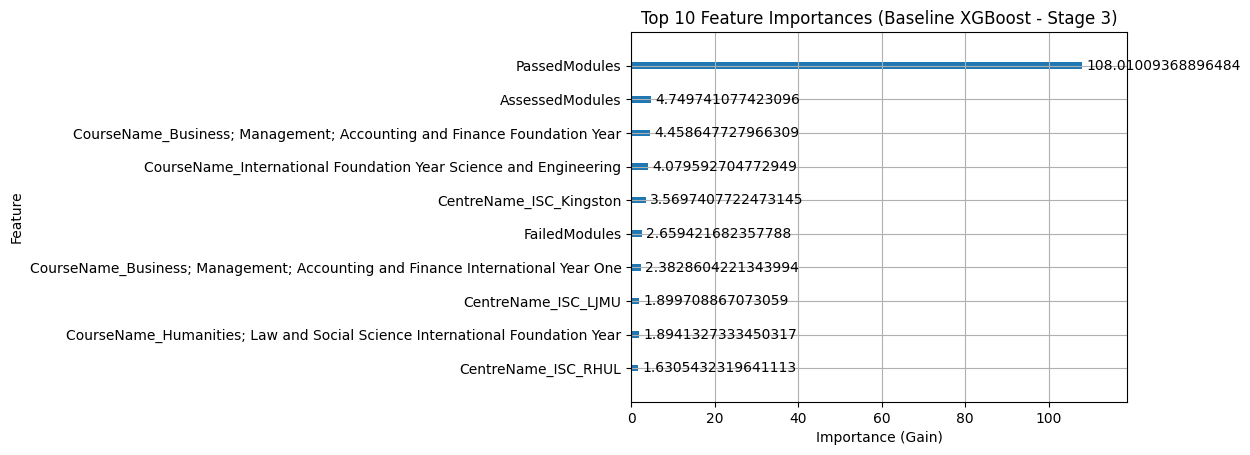

/tmp/ipython-input-1758773094.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


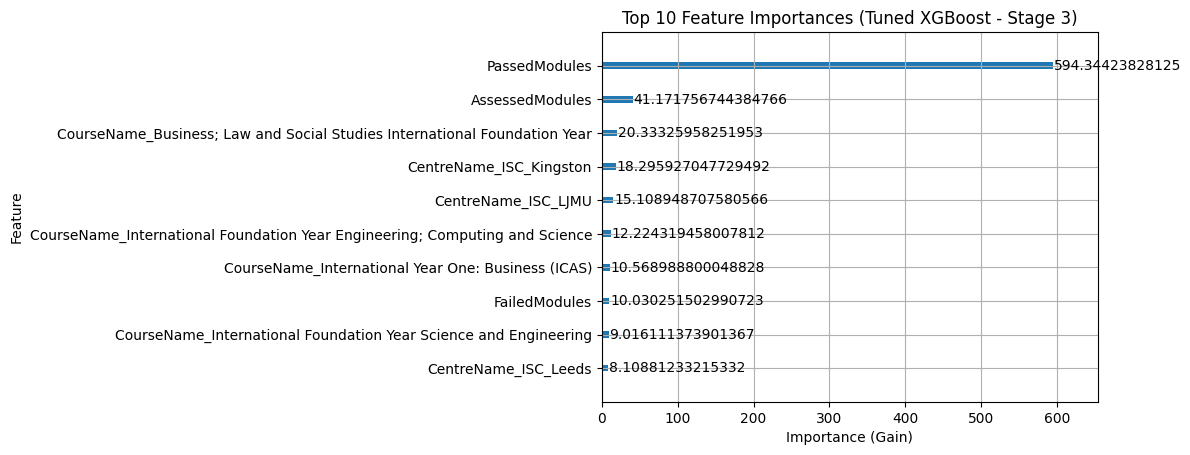

In [109]:
#Plot the feature importance with Stage 1 tuned XGBoost model
plot_xgboost_feature_importance(baseline_xgb_model_stage3['xgb_model'], title='Top 10 Feature Importances (Baseline XGBoost - Stage 3)')
plot_xgboost_feature_importance(best_tuned_xgb_stage3['best_tuned_xgb'], title='Top 10 Feature Importances (Tuned XGBoost - Stage 3)')

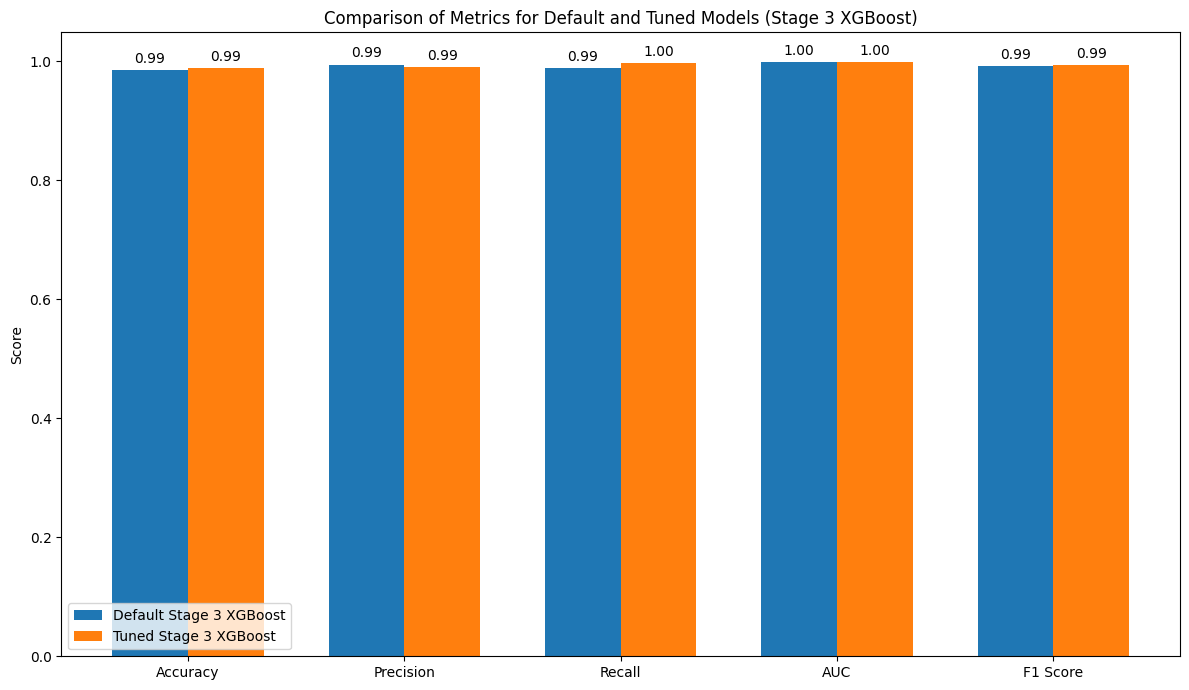

In [110]:
#Plot comparison metrics for Default & Tuned Model (XGBoost) and Heatmap for Confusion Matrix
plot_model_comparison_results(baseline_xgb_model_stage3, best_tuned_xgb_stage3, "Stage 3 XGBoost")

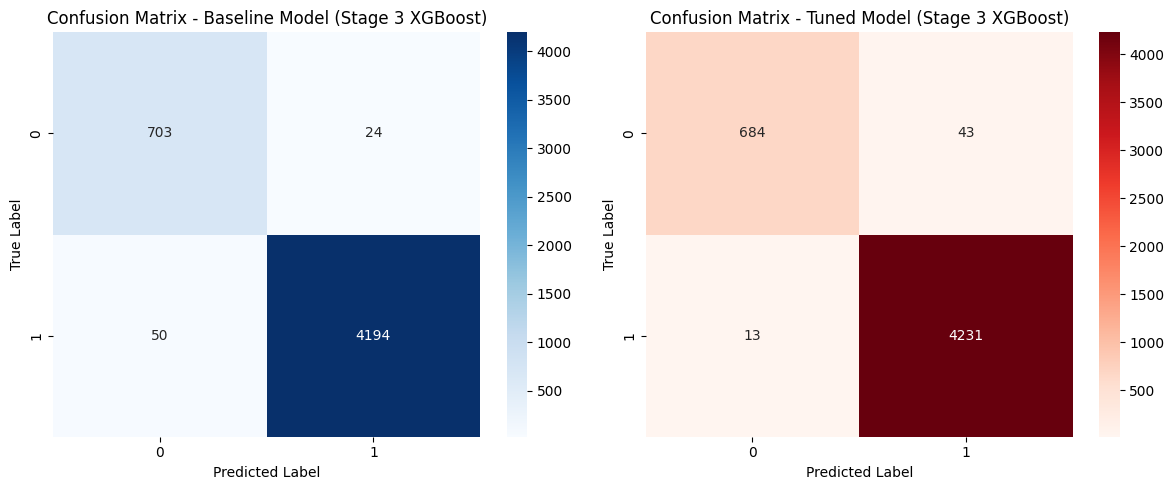

In [111]:
#Plot Heatmap for Confusion Matrix
plot_confusion_metrics_heatmap(baseline_xgb_model_stage3, best_tuned_xgb_stage3, "Stage 3 XGBoost")

**Explanation on Comparison:**
*   **Confusion Matrix**
    * True Positives increased significantly (4201 -> 4230) meaning the tuned model correctly **detects many more positive cases**.
    * False Negatives dropped sharply (43 -> 14) showing the tuned model misses far fewer positive cases
    * False Positives increase a little (25 -> 45), reflecting **slight loss in precision**
    * True Negatives decrease slightly (702 -> 682) consistent with the precision trade-off.
    * Overall **tuned model** becomes much **more sensitive** to **positive class** while sacrificing small amount of precision, a desired trade-off in classification tasks where detecting positive cases is critical.
*   **Metrics Comparison**
    * Accuracy, Precision, AUC and F1 Score show no change, have same results
    * Recall (+0.01) Better at catching positives
*   **Overall Interpretation**
    * The **tuned XGBoost model** shows **near-perfect performance** (Accuracy 0.99, Precision 0.99, Recall 1.00, AUC 1.00, F1 0.99), which is unusually high and **likely too good to be true**, suggesting possible data leakage, target leakage, or overly similar train/test splits.
    * A **deeper investigation** should include **checking for leakage**, verifying train–test separation, inspecting **feature correlations with the target**, reviewing preprocessing pipelines, and evaluating performance on a truly unseen hold-out set or cross-validation to confirm whether the results are genuine or artificially inflated.

#Compare results of NN, XGBoost for all 3 Stages

In [112]:
data = {
    'Model': ['NN', 'NN', 'NN', 'NN', 'NN', 'NN',
              'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost', 'XGBoost'],
    'Tuning': ['Base', 'Tuned', 'Base', 'Tuned', 'Base', 'Tuned',
               'Base', 'Tuned', 'Base', 'Tuned', 'Base', 'Tuned'],
    'Stage': ['Stage 1', 'Stage 1', 'Stage 2', 'Stage 2', 'Stage 3', 'Stage 3',
              'Stage 1', 'Stage 1', 'Stage 2', 'Stage 2', 'Stage 3', 'Stage 3'],
    'Accuracy': [round(baseline_results_stage1['accuracy'], 2), round(best_tuned_model_stage1['accuracy'], 2),
                 round(baseline_results_stage2['accuracy'], 2), round(best_tuned_model_stage2['accuracy'], 2),
                 round(baseline_results_stage3['accuracy'], 2), round(best_tuned_model_stage3['accuracy'], 2),
                 round(baseline_xgb_model_stage1['accuracy'], 2), round(best_tuned_xgb_stage1['accuracy'], 2),
                 round(baseline_xgb_model_stage2['accuracy'], 2), round(best_tuned_xgb_stage2['accuracy'], 2),
                 round(baseline_xgb_model_stage3['accuracy'], 2), round(best_tuned_xgb_stage3['accuracy'], 2)],
    'Precision': [round(baseline_results_stage1['precision'], 2), round(best_tuned_model_stage1['precision'], 2),
                  round(baseline_results_stage2['precision'], 2), round(best_tuned_model_stage2['precision'], 2),
                  round(baseline_results_stage3['precision'], 2), round(best_tuned_model_stage3['precision'], 2),
                  round(baseline_xgb_model_stage1['precision'], 2), round(best_tuned_xgb_stage1['precision'], 2),
                  round(baseline_xgb_model_stage2['precision'], 2), round(best_tuned_xgb_stage2['precision'], 2),
                  round(baseline_xgb_model_stage3['precision'], 2), round(best_tuned_xgb_stage3['precision'], 2)],
    'Recall': [round(baseline_results_stage1['recall'], 2), round(best_tuned_model_stage1['recall'], 2),
               round(baseline_results_stage2['recall'], 2), round(best_tuned_model_stage2['recall'], 2),
               round(baseline_results_stage3['recall'], 2), round(best_tuned_model_stage3['recall'], 2),
               round(baseline_xgb_model_stage1['recall'], 2), round(best_tuned_xgb_stage1['recall'], 2),
               round(baseline_xgb_model_stage2['recall'], 2), round(best_tuned_xgb_stage2['recall'], 2),
               round(baseline_xgb_model_stage3['recall'], 2), round(best_tuned_xgb_stage3['recall'], 2)],
    'AUC': [round(baseline_results_stage1['auc'], 2), round(best_tuned_model_stage1['auc'], 2),
            round(baseline_results_stage2['auc'], 2), round(best_tuned_model_stage2['auc'], 2),
            round(baseline_results_stage3['auc'], 2), round(best_tuned_model_stage3['auc'], 2),
            round(baseline_xgb_model_stage1['auc'], 2), round(best_tuned_xgb_stage1['auc'], 2),
            round(baseline_xgb_model_stage2['auc'], 2), round(best_tuned_xgb_stage2['auc'], 2),
            round(baseline_xgb_model_stage3['auc'], 2), round(best_tuned_xgb_stage3['auc'], 2)],
    'F1 Score': [round(baseline_results_stage1['f1_score'], 2), round(best_tuned_model_stage1['f1_score'], 2),
                 round(baseline_results_stage2['f1_score'], 2), round(best_tuned_model_stage2['f1_score'], 2),
                 round(baseline_results_stage3['f1_score'], 2), round(best_tuned_model_stage3['f1_score'], 2),
                 round(baseline_xgb_model_stage1['f1_score'], 2), round(best_tuned_xgb_stage1['f1_score'], 2),
                 round(baseline_xgb_model_stage2['f1_score'], 2), round(best_tuned_xgb_stage2['f1_score'], 2),
                 round(baseline_xgb_model_stage3['f1_score'], 2), round(best_tuned_xgb_stage3['f1_score'], 2)]
}

results_df = pd.DataFrame(data)

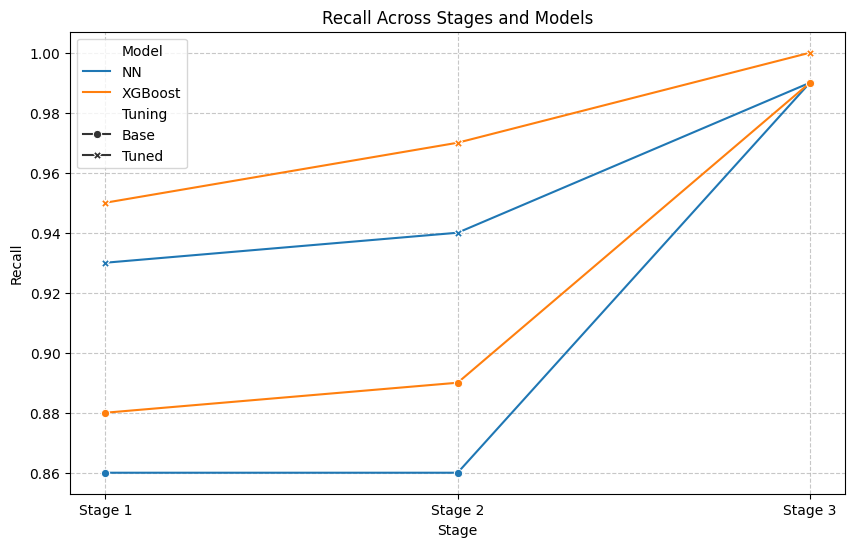

In [119]:
plt.figure(figsize=(10,6))
sns.lineplot(data=results_df, x='Stage', y='Accuracy',
             hue='Model', style='Tuning', markers=True, dashes=False)
plt.title('Accuracy Across Stages and Models')
plt.xlabel('Stage')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

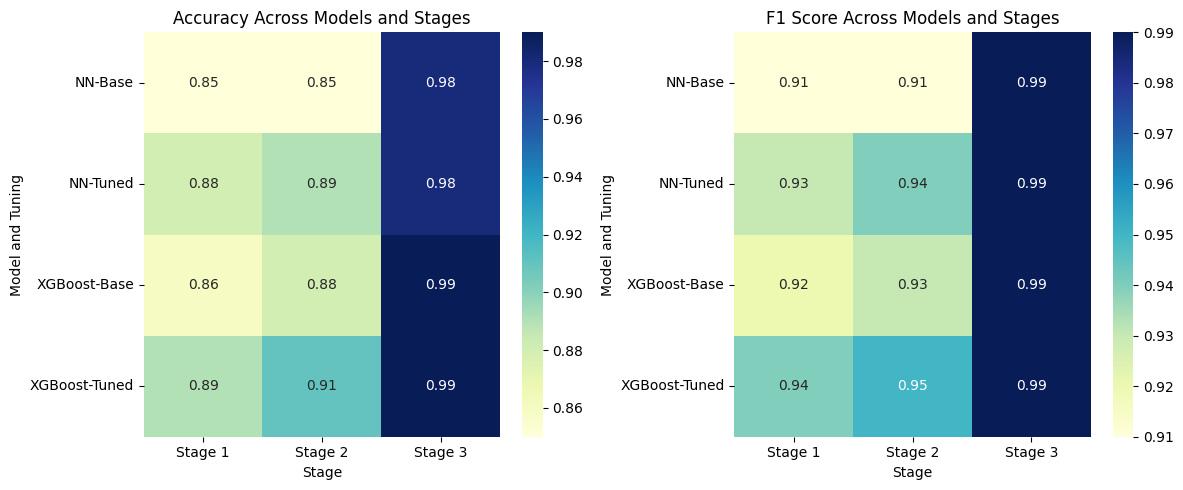

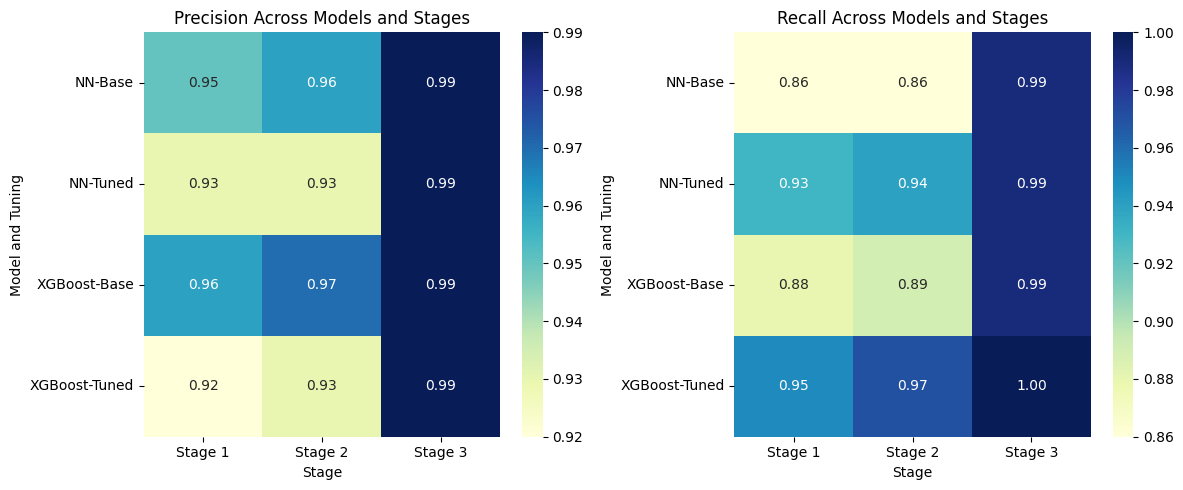

In [114]:
metrics_to_plot = ['Accuracy', 'F1 Score'] # Select three metrics for the row
fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 5)) # Create a figure with a row of subplots

for i, metric in enumerate(metrics_to_plot):
    pivot = results_df.pivot_table(index=['Model', 'Tuning'], columns='Stage', values=metric)
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".2f", ax=axes[i]) # Plot on the corresponding subplot
    axes[i].set_title(f'{metric} Across Models and Stages') # Set title for each subplot
    axes[i].set_xlabel('Stage')
    axes[i].set_ylabel('Model and Tuning')

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

metrics_to_plot = ['Precision', 'Recall'] # Select three metrics for the row
fig, axes = plt.subplots(1, 2, figsize=(6 * 2, 5)) # Create a figure with a row of subplots

for i, metric in enumerate(metrics_to_plot):
    pivot = results_df.pivot_table(index=['Model', 'Tuning'], columns='Stage', values=metric)
    sns.heatmap(pivot, annot=True, cmap='YlGnBu', fmt=".2f", ax=axes[i]) # Plot on the corresponding subplot
    axes[i].set_title(f'{metric} Across Models and Stages') # Set title for each subplot
    axes[i].set_xlabel('Stage')
    axes[i].set_ylabel('Model and Tuning')

plt.tight_layout() # Adjust layout to prevent overlapping
plt.show()

#Feature Importance Summarised by Stage (or Theme)

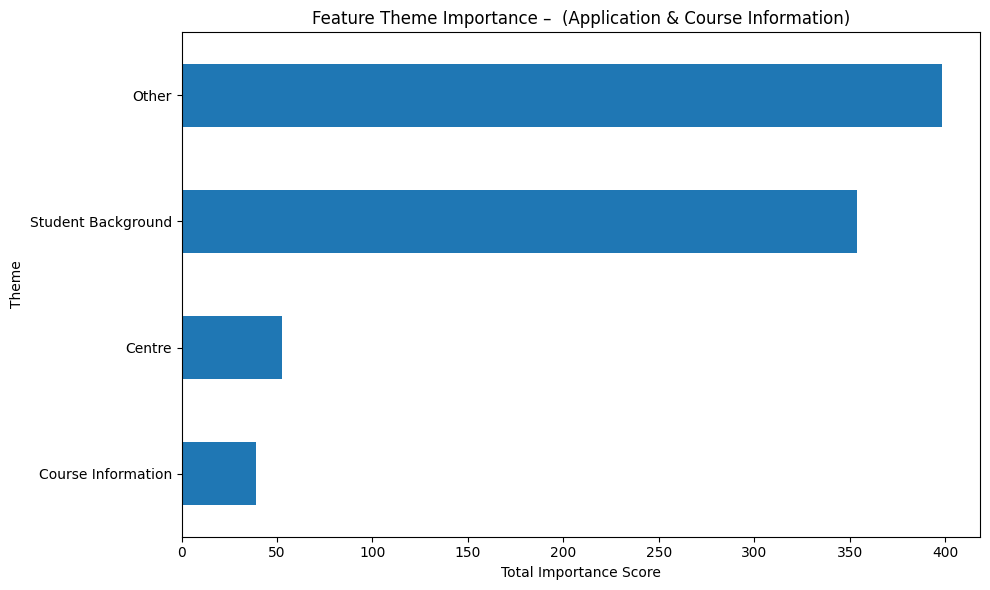

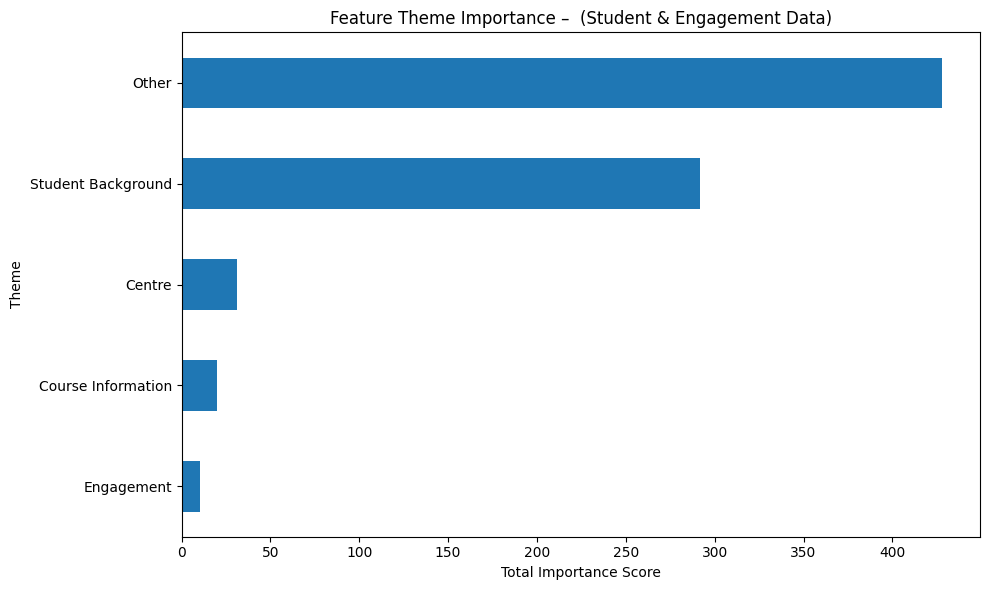

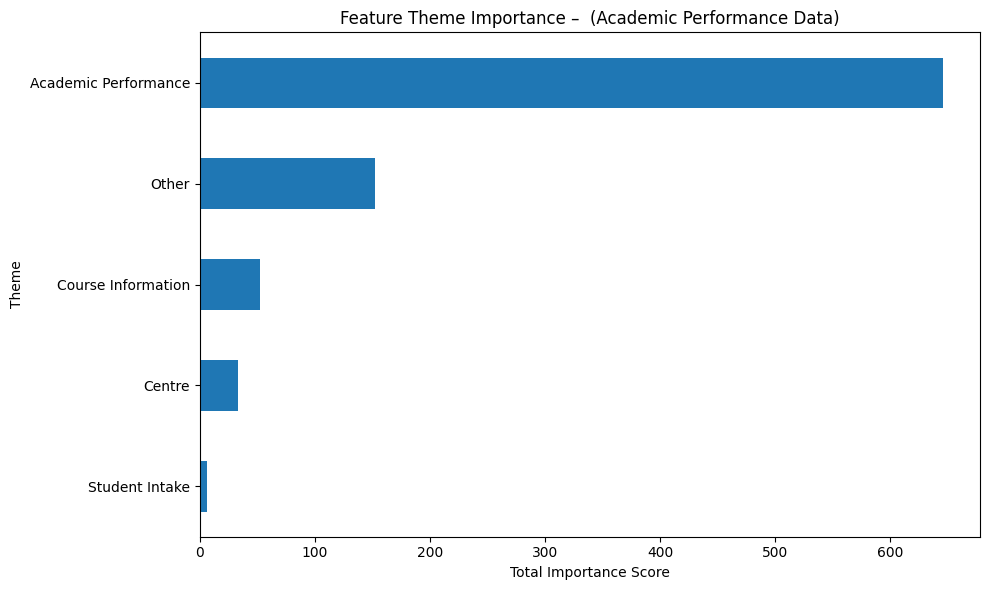

In [118]:
theme_map_stage1 = {
    # Student Background
    "Nationality_Indian": "Student Background",
    "Nationality_Bangladeshi": "Student Background",
    "Nationality_Pakistani": "Student Background",

    # Centre
    "CentreName_ISC_London": "Centre",
    "CentreName_ISC_Sheffield": "Centre",
    "CentreName_ISC_Leeds": "Centre",
    "CentreName_ISC_Durham": "Centre",

    # Course Information
    "CourseLevel": "Course Information",
    "CourseName_International Year One Business and Management - ICAS": "Course Information",
    "CourseName_Business; Management; Accounting and Finance International Year One": "Course Information"
}

theme_map_stage2 = {
    # Student Background
    "Nationality_Bangladeshi": "Student Background",
    "Nationality_Indian": "Student Background",
    "Nationality_Pakistani": "Student Background",
    "Nationality_Sri Lankan": "Student Background",

    # Centre
    "CentreName_ISC_Sheffield": "Centre",
    "CentreName_ISC_Sussex": "Centre",
    "CentreName_ISC_Kingston": "Centre",

    # Course Information
    "CourseName_International Year One Business and Management - ICAS": "Course Information",
    "CourseName_Business; Management; Accounting and Finance International Foundation Year": "Course Information",

    # Engagement
    "UnauthorisedAbsenceCount": "Engagement"
}

theme_map_stage3 = {
    # Academic Performance
    "PassedModules": "Academic Performance",
    "AssessedModules": "Academic Performance",
    "FailedModules": "Academic Performance",

    # Course Information
    "CourseName_Business; Law and Social Studies International Foundation Year": "Course Information",
    "CourseName_International Year One: Business (ICAS)": "Course Information",
    "CourseName_International Foundation Year Engineering; Computing and Science": "Course Information",
    "CourseName_International Foundation Year Science and Engineering": "Course Information",

    # Centre
    "CentreName_ISC_Kingston": "Centre",
    "CentreName_ISC_LJMU": "Centre",

    # Intake Information
    "IsFirstIntake": "Student Intake"
}

def map_to_theme(feature_name, theme_map):
    for key in theme_map:
        if key in feature_name:
            return theme_map[key]
    return "Other"

def theme_importance_plot(xg, theme_map, theme_name):

  # Extract gain-based importance (best for interpretability)
  importance = xg.get_booster().get_score(importance_type='gain')
  imp_df = pd.DataFrame(list(importance.items()), columns=['feature', 'importance'])

  imp_df['theme'] = imp_df['feature'].apply(lambda x: map_to_theme(x, theme_map))   # OR stage2 / stage3
  theme_importance = imp_df.groupby('theme')['importance'].sum().sort_values()

  plt.figure(figsize=(10,6))
  theme_importance.plot(kind='barh')
  plt.title(f'Feature Theme Importance –  ({theme_name})')
  plt.xlabel("Total Importance Score")
  plt.ylabel("Theme")
  plt.tight_layout()
  plt.show()

theme_importance_plot(best_tuned_xgb_stage1['best_tuned_xgb'], theme_map_stage1, 'Application & Course Information')
theme_importance_plot(best_tuned_xgb_stage2['best_tuned_xgb'], theme_map_stage2, 'Student & Engagement Data')
theme_importance_plot(best_tuned_xgb_stage3['best_tuned_xgb'], theme_map_stage3, 'Academic Performance Data')



###**Conclusion and Future Considerations**
Using the feature importance scores from the best-tuned XGBoost model, we grouped the encoded variables into meaningful business themes for each stage of the student journey. We then visualised the total importance contributed by each theme, allowing us to clearly interpret which factors have the strongest influence on student dropout at each stage. Notably, the ‘Other’ category shows a consistently strong influence across all three stages, indicating that additional underlying features outside the predefined themes also play a significant role and should be explored further.